# 0- Setup

In [1]:
%load_ext autoreload
%autoreload 2

#magic commands 

-Naming convention:
  - g: Egypt dataset 
  - ng:Global dataset without Egypt 
  - w: Global dataset
  - int: Initial dataset without anomalies removal
  - ra: dataset with rating code A 
  - rab: dataset with rating code A or B
  - GHF: dataset containing onservables 
  - grid: grid containing observables 
  - on: heat values with onshore points (contains only on data)
  - off: heat values with offshore points ( almost conatins off and on data)

# 1- Import libraries

In [2]:
#Logging and Warnings
import warnings  # Provides a way to handle warning messages that may occur during the execution of the code.
import logging  # Module for flexible logging of messages and errors.


#Visualization
import matplotlib.pyplot as plt  # Plotting library for creating various types of plots and visualizations.
import seaborn as sns  # Library for creating statistical graphics, such as heatmaps and scatterplots.
import pygmt  # Python interface to the Generic Mapping Tools (GMT) for creating geospatial visualizations.

#File and Path Operations
from pathlib import Path  # Object-oriented filesystem paths.
import pickle  # Module for serializing and deserializing Python objects.


#Data Manipulation and Analysis
import pandas as pd  # Data manipulation and analysis library.
import numpy as np  # Fundamental package for scientific computing with Python.
import xarray as xr # For labeled multi-dimensional arrays and datasets.


# Machine learning library for Python.
from sklearn  import metrics, model_selection, compose, pipeline, ensemble, preprocessing, inspection, feature_selection


#Progress Bars and Delay
from time import sleep  # For adding delay.
from tqdm import tqdm_notebook  # For displaying progress bars.


#Jupyter Display
from IPython.display import display  # Replace print with it in Jupyter.


#Logging Configuration and Ignoring Warnings

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Ignore warnings
warnings.filterwarnings('ignore')


#Directory and Styling
DIR = Path().resolve()  # Current working directory.
sns.set_theme(style="white")  # Set the default theme/style for Seaborn.

# 2- Variables and constants

In [3]:
# Map extents of Egypt
region_g_tpl = (24, 38, 21 , 33)
LON_MIN_G, LON_MAX_G, LAT_MIN_G, LAT_MAX_G =  region_g_tpl

# Set variables
frames_lst = ['NesW', 'Nesw', 'Nesw', 'NEsw', 'NesW', 'Nesw', 'Nesw', 'NEsw', 'NesW', 'Nesw', 'Nesw', 'NEsw']

PANEL_WIDTH = 13
PANEL_HEIGHT = PANEL_WIDTH * ((region_g_tpl[3]-region_g_tpl[2]) / (region_g_tpl[1]-region_g_tpl[0]))

margins_tpl = ("0.7c", "2c")

PROJECTION = 'M5.4i'

coast_kwargs = {
    "projection": PROJECTION,
    "water": "lightblue",
    "shorelines": "0.1p,black",
    "borders": ["1/0.01p,black"],
    "lakes": "lightblue",
    "rivers": "lightblue",
    #"dcw": "=AS,=EU+gdarkgrey"
}

base_kwargs = {
    "region": region_g_tpl,
    "projection": PROJECTION,
}

gridimage_kwargs = {
    "projection": PROJECTION,
    "cmap": True,
    "interpolation": "b",
    "dpi": 'i',
}

#temp_kwargs = {
#    "cmap": 'haxby',
#    "series": '30/120',
#    "reverse": False
#}

#temp_kwargs = {
#    "cmap": DIR / 'GMT' / 'temperature.cpt',
#    "series": '30/120',
#    "reverse": False
#}

#i have problem here in the directory so i put this file in other folder
temp_kwargs = {
    "cmap": r"C:\Users\Public\AFQ\GMT\temperature.cpt",
    "series": '30/120',##review the scalee
    "reverse": False
}

colorbar_h = f"g{str(region_g_tpl[0])}/{str(region_g_tpl[2]-1)}+w{PANEL_WIDTH}c/0.5c+h+e"

### Constants relative to figures

In [4]:
#Set global plt parameters
plt_params = {
    'figure.titlesize' : 28,
    "axes.titlesize" : 25, # main
    "axes.labelsize" : 25,  # labels
    "axes.edgecolor" : "black", 
    "axes.linewidth" : 1, 
    'xtick.labelsize': 20, # ticks
    'ytick.labelsize': 20,
    'legend.title_fontsize':17,
    'legend.fontsize': 17,
    'font.size': 20,
}

# Sub figures
sub_figs = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ123456789')
#sub_figs = list('abcdefghijklmnopqrstuvwxyz123456789')


In [5]:
#Initialize a dictionary called obs with different lists as values.
obs_dict = {
    'REF_CODE_UNTRANS': ['CTD' , 'SI', 'LAB', 'MOHO', 'VS_VELOCITY', 'VP_VELOCITY', 'GEOID', 'FA', 'DEM', 'BG', 'EMAG2', 'RHO_L', 'RHO_C', 'VOLCS_DIST', 'REG', 'GLIM'],
    'REF_CODE': ['CTD' , 'SI', 'LAB', 'MOHO', 'VS', 'VP', 'GEOID', 'FA', 'DEM', 'BG', 'EMAG2_CLASS', 'RHO_L', 'RHO_C', 'VOLCS_DIST_W', 'REG', 'GLIM'],
    'LABELS': ['Curie Depth', 'Shape Index', 'LAB Depth', 'Moho Depth', 'Δ$S_v$ @150km tomography', 'Δ$P_v$ @150Km tomography', 'Geoid', 'Free Air Anomaly', 'DEM', 'Bouguer Anomaly', 'Magnetic Anomaly', 'Litho. ρ', 'Crustal ρ', 'Proximity to Volcano', 'Tectonic Regions', 'Litho. Map'],
    'LABELS_gmt': ['Curie Depth', 'Shape index', 'LAB Depth', 'Moho Depth', '@~D@~S@_v@ @@150km tomography', '@~D@~P@_v@ @@150km tomography', 'Geoid', 'Free air Anomaly', 'DEM', 'Bouguer Anomaly', 'Magnetic Anomaly', 'Lith. @~r@ ', 'Crustal @~r@ ', 'Proximity to Volcano', 'Tectonic Regions', 'Litho. Map'],
    'LABELS_gmt_UNTRANS': ['Curie Depth', 'Shape index', 'LAB Depth', 'Moho Depth', 'S@_v@ @@150km tomography', 'P@_v@ @@150km tomography', 'Geoid', 'Free air Anomaly', 'DEM', 'Bouguer Anomaly', 'Magnetic Anomaly', 'Lith. @~r@ ', 'Crustal @~r@ ', 'Distance to Volcano', 'Tectonic Regions', 'Litho. Map'],
    'UNITS': ['km', 'si', 'km', 'km', '%', '%', 'm', 'mGal', 'm', 'mGal', 'f(nT)', 'kgm$^{-3}$', 'kgm$^{-3}$', 'f(Km)', 'class', 'class'],
    'UNITS_gmt': ['km', 'si', 'km', 'km', '%', '%', 'm', 'mGal', 'm', 'mGal', 'f(nT)', 'kgm@+-3@', 'kgm@+-3@', 'f(Km)', 'class', 'class'],
    'UNITS_gmt_UNTRANS': ['km', 'si', 'km', 'km', 'ms@+-2@', 'ms@+-2@', 'm', 'mGal', 'm', 'mGal', 'nT', 'kgm@+-3@', 'kgm@+-3@', 'Km', 'class', 'class'],
    'V_RANGE_W': [(0,50), (-1,1), (0,300), (15,60), (-0.1,0.1), (-0.02,0.02), (-45,45), (-100,100), (-2200, 2200),(-100,100), (-0.4, 0.4), (3260, 3360), (2650, 2950), (0,1), (1,6), (1,16)],
    'V_RANGE_G': [(10,45), (-1,1), (50,140), (20,40), (-0.075,0.075), (-0.01,0.0025), (0,30), (-90,90), (-2200, 2200),(-90,90), (-0.4, 0.4), (3260, 3360), (2650, 2850), (0,1), (1,5), (1,15)],
    'V_RANGE_G_UNTRANS': [(10, 50), (-1, 1), (50, 200), (20, 45), (4100, 4800), (7700, 8300), (-45, 45), (-100, 100), (-2200, 2200), (-100, 100), (-200, 200),(3260, 3360), (2650, 2950), (0, 300), (1, 6), (1, 15)],
    #'CMAPS': ['batlow', 'broc', 'bamako', 'batlow', 'roma', 'roma', 'bamako', 'broc', 'bukavu', 'broc', 'batlow', 'batlow', 'batlow', 'bamako', 'batlowS', 'categorical'],
    'CMAPS_gmt': ['SCM/roma', 'SCM/broc', 'SCM/batlow', 'SCM/batlow', 'SCM/roma', 'SCM/roma', 'SCM/vik', 'SCM/vik', 'gmt/geo', 'SCM/vik', 'SCM/vik','SCM/broc', 'SCM/broc', 'SCM/vik', 'gmt/categorical', 'gmt/categorical']
}

# Reorder references
# rearrange the dataframe with new orders 
updated_index = [0, 3, 2, 4, 5, 11, 12, 6, 7, 9, 1, 8, 10, 13, 14, 15]

# Set the maximum display width of columns in pandas DataFrame to 370.
pd.options.display.width = 370

# Set the maximum display width of a single column in pandas DataFrame to 16.
pd.options.display.max_colwidth = 16

#make it as a a data frame
obs_df = pd.DataFrame(obs_dict)

# Reindex OBS based on the new index new_index.
obs_df = obs_df.reindex(updated_index)

# Set OBS_REF as index, making it easy to access by referencing observable
#make the 'RED_CODE' as the index labels
obs_df = obs_df.set_index('REF_CODE')

obs_df

#save to check
#obs_df.to_csv(DIR/f'Obs.csv', index=False, encoding='utf-8')

,REF_CODE_UNTRANS,LABELS,LABELS_gmt,LABELS_gmt_UNTRANS,UNITS,UNITS_gmt,UNITS_gmt_UNTRANS,V_RANGE_W,V_RANGE_G,V_RANGE_G_UNTRANS,CMAPS_gmt
REF_CODE,,,,,,,,,,,
CTD,CTD,Curie Depth,Curie Depth,Curie Depth,km,km,km,"(0, 50)","(10, 45)","(10, 50)",SCM/roma
MOHO,MOHO,Moho Depth,Moho Depth,Moho Depth,km,km,km,"(15, 60)","(20, 40)","(20, 45)",SCM/batlow
LAB,LAB,LAB Depth,LAB Depth,LAB Depth,km,km,km,"(0, 300)","(50, 140)","(50, 200)",SCM/batlow
VS,VS_VELOCITY,Δ$S_v$ @150k...,@~D@~S@_v@ @...,S@_v@ @@150k...,%,%,ms@+-2@,"(-0.1, 0.1)","(-0.075, 0.075)","(4100, 4800)",SCM/roma
VP,VP_VELOCITY,Δ$P_v$ @150K...,@~D@~P@_v@ @...,P@_v@ @@150k...,%,%,ms@+-2@,"(-0.02, 0.02)","(-0.01, 0.0025)","(7700, 8300)",SCM/roma
RHO_L,RHO_L,Litho. ρ,Lith. @~r@,Lith. @~r@,kgm$^{-3}$,kgm@+-3@,kgm@+-3@,"(3260, 3360)","(3260, 3360)","(3260, 3360)",SCM/broc
RHO_C,RHO_C,Crustal ρ,Crustal @~r@,Crustal @~r@,kgm$^{-3}$,kgm@+-3@,kgm@+-3@,"(2650, 2950)","(2650, 2850)","(2650, 2950)",SCM/broc
GEOID,GEOID,Geoid,Geoid,Geoid,m,m,m,"(-45, 45)","(0, 30)","(-45, 45)",SCM/vik
FA,FA,Free Air Ano...,Free air Ano...,Free air Ano...,mGal,mGal,mGal,"(-100, 100)","(-90, 90)","(-100, 100)",SCM/vik


In [6]:
# Set variable values
TARGET       = 'GHF'
TARGET_LABEL = 'Heat Flow'
COORDs       = ['lon', 'lat']
GRID_INDEX_W = 'grid_index_w'
GRID_INDEX_G = 'grid_index_g'
GHF_BOUNDS   = (10, 200)

# Create full header names with short labels of observables for World and egypt
observables_lst   = obs_df.index.tolist()
observables_w_lst = observables_lst + COORDs + [GRID_INDEX_W, TARGET]
observables_g_lst = observables_lst + COORDs + [GRID_INDEX_G, TARGET]

# Create header names with short labels of observables
observables_ghf_lst = observables_lst + [TARGET]

# Create full header names with long labels of observables for World and egypt
labels_lst   = obs_df.loc[observables_lst, 'LABELS'].values.tolist()
labels_w_lst = labels_lst + ['lon', 'lat', GRID_INDEX_W, TARGET]
labels_g_lst = labels_lst + ['lon', 'lat', GRID_INDEX_G, TARGET]

# Create header names with long labels of observables
labels_ghf_lst = labels_lst + [TARGET_LABEL]


#print('observables_lst')
#print(observables_lst)
#print('observables_w_lst')
#print(observables_w_lst)
#print('observables_g_lst')
#print(observables_g_lst)
#print('observables_ghf_lst')
#print(observables_ghf_lst)
#print('labels_lst')
#print(labels_lst)
#print('labels_w_lst')
#print(labels_w_lst)
#print('labels_g_lst')
#print(labels_g_lst)
#print('labels_ghf_lst')
#print(labels_ghf_lst)

### Load datasets

In [7]:
# this line will take g_off_ra dataset and use obervables as X and GHF as y

In [9]:
#load egypt grid with all its observables
#i have problem here in the directory so i put this file in other folder
grid_g_xr = xr.load_dataset(r"C:\Users\Public\AFQ\Grids\Inputs\grid_g.nc")

#get observables from grid for prediction
grid_g_df = grid_g_xr.to_dataframe()
grid_g_df['GLIM'] = grid_g_df['GLIM'].astype(int).astype('category')
grid_g_df['REG'] = grid_g_df['REG'].astype(int).astype('category')


# Set file paths
#use Egypt data which processed include onshore and offshore points 
ghf_f = DIR / 'Dataset' / 'Preprocessed' / f'g_off_ra.csv' 

#Load the tuned hyperparameters
tuned_hyperparameters_f = DIR / 'Hyperparameters' / 'hyperparameters.pkl'

# Read CSV file and convert columns to appropriate data types
ghf_df = pd.read_csv(ghf_f, sep='\t')[observables_g_lst]
ghf_df['GLIM'] = ghf_df['GLIM'].astype('category')
ghf_df['REG']  = ghf_df['REG'].astype('category')


#get observables from GHF training
X = ghf_df[observables_lst] 
y = ghf_df[TARGET].values.reshape(-1, 1) 

# Load the best hyperparameters using pickle
with open(tuned_hyperparameters_f, 'rb') as f:
    tuned_hyperparameters = pickle.load(f)

#print(X)
#print(y)

### Helper functions

In [10]:
#Computes the Concordance Correlation Coefficient (CCC) between the true and predicted values
def concordance_correlation_coefficient(df, y_true, y_pred):
    """Concordance correlation coefficient."""
    
    # Reshape the input arrays
    y_true = y_true.ravel().reshape(-1,)
    y_pred = y_pred.ravel().reshape(-1,)
    
    # Remove NaNs from the input data
    df = pd.DataFrame({
        'y_true': y_true,
        'y_pred': y_pred
    })
    df = df.dropna()
    y_true = df['y_true']
    y_pred = df['y_pred']
    
    # Compute the Pearson product-moment correlation coefficient
    cor = np.corrcoef(y_true, y_pred)[0][1]
    
    # Compute the mean of the true and predicted values
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    
    # Compute the variance of the true and predicted values
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    
    # Compute the standard deviation of the true and predicted values
    sd_true = np.std(y_true)
    sd_pred = np.std(y_pred)
    
    # Calculate the CCC
    numerator = 2 * cor * sd_true * sd_pred
    denominator = var_true + var_pred + (mean_true - mean_pred)**2
    return numerator / denominator

# Define a function to compute the normalized root-mean-square error (NRMSE)
def nrmse(y_true, y_pred):
    cost  = mean_squared_error(y_true, y_pred, squared=False)
    return cost/(y_true.mean()) 

# Define a function to compute the accuracy score
def accuracy(y_true, y_pred):
    cost  = mean_absolute_percentage_error(y_true, y_pred)
    return (100 - (cost * 100)) 

# Define a function to compute the minimum absolute error
def min_e(y_true, y_pred):
    cost  = abs(y_true - y_pred)
    return cost.min()

# Define a function to compute the mean percentage error (MPE)
def mpe(y_true, y_pred):
    return np.mean((y_true -y_pred)/y_true) 

# Define a function that calculates the coefficient of variation
def coefficient_variation(x):
    mu = x.mean()
    residual = x - mu
    return (np.sqrt(np.power(residual,2))/mu)* 100

# Define a dictionary with all the scoring functions for cross-validation
scorings_dict = {
    'RMSe'     :  metrics.make_scorer(metrics.mean_squared_error , squared=False),
    #'NRMSe'   :  metrics.make_scorer(nrmse),
    #'MAe'     : metrics.make_scorer(metrics.mean_absolute_error),    
    #'MAPe'    :  metrics.make_scorer(metrics.mean_absolute_percentage_error ),
    #'ACC'     :  metrics.make_scorer(accuracy) ,
    #'MPe'     :  metrics.make_scorer(mpe),
    'CD'       :  metrics.make_scorer(metrics.r2_score),
    #'EV'      :  metrics.make_scorer(metrics.explained_variance_score),
    #'MAX_e'   :  metrics.make_scorer(metrics.max_error),
    #'MIN_e'   :  metrics.make_scorer(min_e),
    #'MED_Ae'   :  metrics.make_scorer(metrics.median_absolute_error),
    #'CCC'     :  metrics.make_scorer(concordance_correlation_coefficient),
}


# Define scoring function and cross-validation object
#SCORING = make_scorer(nrmse)

In [11]:
# Set constants and variables
KFOLD = 5  # Number of folds for cross-validation
N_ITER = 50  # Number of iterations
RANDOM_STATE = 42  # Random state for reproducibility
N_JOBS = 1  # Number of jobs to run in parallel
VERBOSE = 2  # Verbosity level
N_REPAT = 16

#Kfold CV
#cv_fnct = sk.model_selection.RepeatedKFold(n_splits=KFOLD, random_state=RANDOM_STATE, n_repeats=N_REPAT)
cv_fnct = model_selection.KFold(n_splits=KFOLD, random_state=RANDOM_STATE, shuffle=True)


# Define preprocessing pipeline
numeric_transformer_fnct = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True)
numeric_transformer_target = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True)
categorical_transformer_fnct = preprocessing.OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Define preprocessing pipeline
preprocessor = compose.ColumnTransformer(
    transformers=[
           ("num", numeric_transformer_fnct, compose.make_column_selector(dtype_exclude="category")),
           ("cat", categorical_transformer_fnct, compose.make_column_selector(dtype_include="category")),
    ], 
)


# Modify the parameter names to be compatible with the regressor, RFE, RFECV object
tuned_hyperparameters_regressor = {item.replace('ttr__regressor__', ''):
                tuned_hyperparameters[item] for item in tuned_hyperparameters}

tuned_hyperparameters_rfe_ttr = {item.replace('ttr__regressor__', 'regressor__rfe__estimator__'):
                tuned_hyperparameters[item]  for item in tuned_hyperparameters}

tuned_hyperparameters_rfecv_ttr = {item.replace('ttr__regressor__', 'regressor__rfecv__estimator__'): 
                tuned_hyperparameters[item] for item in tuned_hyperparameters}


# Define regression pipeline
regressor = ensemble.RandomForestRegressor(random_state=RANDOM_STATE)


steps_lst=[("preprocessor", preprocessor), 
       #("regressor", regressor), 
       ('ttr', compose.TransformedTargetRegressor(regressor=regressor, 
                                                  transformer=numeric_transformer_target))
]

# Initialize Pipeline object
pipeline_fnt = pipeline.Pipeline(steps=steps_lst)
pipeline_fnt.set_params(**tuned_hyperparameters)
pipeline_fnt['ttr'].regressor


RandomForestRegressor(max_depth=28, max_features=13, min_samples_leaf=2,
                      n_estimators=880, random_state=42)

# 2- Observables ranking

### Relative importance

In [12]:
logging.info('Fitting') 

# calculate importance

#fit optimized pipeline
pipeline_fnt.fit(X, y)

# Get the feature importance using Random Forest's feature_importances_ attribute
observables_importance_df = pd.DataFrame({
    "LABELS"        : labels_lst,
    "REF_CODE_TRANS": observables_lst,
    "RI"            : pipeline_fnt['ttr'].regressor_.feature_importances_.round(3),
}).set_index('LABELS')

logging.info('Terminated') 

observables_importance_df.sort_values(by="RI", ascending=False)



2024-08-01 20:51:07,653 - INFO - Fitting
2024-08-01 20:51:24,538 - INFO - Terminated


,REF_CODE_TRANS,RI
LABELS,,
Moho Depth,MOHO,0.317
DEM,DEM,0.127
Curie Depth,CTD,0.123
Δ$S_v$ @150km tomography,VS,0.096
Free Air Anomaly,FA,0.083
Bouguer Anomaly,BG,0.059
Geoid,GEOID,0.057
Magnetic Anomaly,EMAG2_CLASS,0.046
Shape Index,SI,0.036


In [14]:
#save to check
observables_importance_df=(observables_importance_df.sort_values(by="RI", ascending=False))
observables_importance_df.to_csv(DIR/'Fig'/f'Obs_ra_Importance.csv', index=False, encoding='utf-8')

### Permutation importance

In [15]:
permutations_importance_dict = {}

logging.info('Processing') 

for key, scoring in scorings_dict.items():
    #Compute the permutation observable importance
    permutations_dict = inspection.permutation_importance(pipeline_fnt, X, y, n_repeats=KFOLD, \
                                                 scoring=scoring, random_state=RANDOM_STATE)

    # Get the permutation observable importance scores
    observables_importance_df[f"PFI_{key}"] = permutations_dict.importances_mean.round(3)
    observables_importance_df[f"PFI_{key}_std"] = permutations_dict.importances_std.round(3)
    permutations_importance_dict[key] = pd.DataFrame(permutations_dict['importances'])

logging.info('Terminated') 

observables_importance_df
observables_importance_df.to_csv(DIR/'Fig'/f'Obs_ra_Importance_PI.csv', index=False, encoding='utf-8')

2024-08-01 20:52:02,203 - INFO - Processing
2024-08-01 20:52:46,753 - INFO - Terminated


In [16]:
#save to check
observables_importance_df.to_csv(DIR/'Fig'/f'Obs_ra_Importance_PI.csv', index=False, encoding='utf-8')

### RFE ranking

In [17]:
observable_int_dict = {}

rfe_dict = {}
logging.info('Fitting') 

for i in tqdm_notebook(range(obs_df.shape[0]), desc = 'Observable: '):
    sleep(0.01)

    # Create a pipeline with RFE and a linear regression estimator
    pipeline_rfe = pipeline.make_pipeline(
        preprocessor,
        feature_selection.RFE(estimator=ensemble.RandomForestRegressor(
            random_state=RANDOM_STATE), n_features_to_select=i+1),
        ensemble.RandomForestRegressor(random_state=RANDOM_STATE)
    )

    # Use TransformedTargetRegressor to apply a normalize the target variable
    pipeline_rfe_ttr = compose.TransformedTargetRegressor(regressor=pipeline_rfe, transformer=numeric_transformer_target)

    pipeline_rfe_ttr.set_params(**tuned_hyperparameters_rfe_ttr)
    # Fit the pipeline
    pipeline_rfe_ttr.fit(X, y)
    
    # Select the current observable and convert it to a dataframe   
    X_rfe = X[pipeline_rfe_ttr.regressor_['rfe'].get_feature_names_out(observables_lst)]
    
    
    # Find the ranked elements
    observable_rfe = set(pipeline_rfe_ttr.regressor_['rfe'].get_feature_names_out(observables_lst)) - set(observable_int_dict)
    
    logging.info(f" Rank {i+1} Element ", observable_rfe)
    
    for key, scoring in tqdm_notebook(scorings_dict.items(), desc = 'Scoring: '):
        
        observables_importance_df.loc[obs_df.loc[list(observable_rfe), 'LABELS'], 'RANKING'] = int(i+1)       
        # Store the mean score for the current observable in the observables_importance_df dataframe
        observables_importance_df.loc[obs_df.loc[list(observable_rfe), 'LABELS'], f"RFE_{key}"] = np.mean(
         model_selection.cross_val_score(
         pipeline_fnt, 
         X_rfe, 
         y,
         scoring=scoring, 
         n_jobs=N_JOBS,
         cv=cv_fnct)).round(3)
        
        observables_importance_df.loc[obs_df.loc[list(observable_rfe), 'LABELS'], f"RFE_{key}_std"] = np.std(
         model_selection.cross_val_score(
         pipeline_fnt, 
         X_rfe, 
         y,
         scoring=scoring, 
         n_jobs=N_JOBS,
         cv=cv_fnct)).round(3)
        rfe_dict[ f"{observable_rfe}_{key}"] = model_selection.cross_val_score(
            pipeline_fnt, 
            X_rfe, 
            y,
            scoring=scoring, 
            n_jobs=N_JOBS,
            cv=cv_fnct).round(3)
        
    observable_int_dict = pipeline_rfe_ttr.regressor_['rfe'].get_feature_names_out(observables_lst)

logging.info('Terminated') 

observables_importance_df

2024-08-01 20:52:48,091 - INFO - Fitting


Observable:   0%|          | 0/16 [00:00<?, ?it/s]

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 1083, in emit
    msg = self.format(record)
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 927, in format
    return fmt.format(record)
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 663, in format
    record.message = record.getMessage()
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 367, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\site-packages\ipyk

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 1083, in emit
    msg = self.format(record)
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 927, in format
    return fmt.format(record)
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 663, in format
    record.message = record.getMessage()
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 367, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\site-packages\ipyk

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 1083, in emit
    msg = self.format(record)
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 927, in format
    return fmt.format(record)
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 663, in format
    record.message = record.getMessage()
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 367, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\site-packages\ipyk

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 1083, in emit
    msg = self.format(record)
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 927, in format
    return fmt.format(record)
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 663, in format
    record.message = record.getMessage()
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 367, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\site-packages\ipyk

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 1083, in emit
    msg = self.format(record)
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 927, in format
    return fmt.format(record)
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 663, in format
    record.message = record.getMessage()
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 367, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\site-packages\ipyk

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 1083, in emit
    msg = self.format(record)
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 927, in format
    return fmt.format(record)
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 663, in format
    record.message = record.getMessage()
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 367, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\site-packages\ipyk

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 1083, in emit
    msg = self.format(record)
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 927, in format
    return fmt.format(record)
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 663, in format
    record.message = record.getMessage()
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 367, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\site-packages\ipyk

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 1083, in emit
    msg = self.format(record)
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 927, in format
    return fmt.format(record)
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 663, in format
    record.message = record.getMessage()
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 367, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\site-packages\ipyk

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 1083, in emit
    msg = self.format(record)
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 927, in format
    return fmt.format(record)
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 663, in format
    record.message = record.getMessage()
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 367, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\site-packages\ipyk

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 1083, in emit
    msg = self.format(record)
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 927, in format
    return fmt.format(record)
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 663, in format
    record.message = record.getMessage()
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 367, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\site-packages\ipyk

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 1083, in emit
    msg = self.format(record)
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 927, in format
    return fmt.format(record)
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 663, in format
    record.message = record.getMessage()
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 367, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\site-packages\ipyk

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 1083, in emit
    msg = self.format(record)
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 927, in format
    return fmt.format(record)
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 663, in format
    record.message = record.getMessage()
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 367, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\site-packages\ipyk

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 1083, in emit
    msg = self.format(record)
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 927, in format
    return fmt.format(record)
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 663, in format
    record.message = record.getMessage()
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 367, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\site-packages\ipyk

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 1083, in emit
    msg = self.format(record)
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 927, in format
    return fmt.format(record)
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 663, in format
    record.message = record.getMessage()
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 367, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\site-packages\ipyk

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 1083, in emit
    msg = self.format(record)
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 927, in format
    return fmt.format(record)
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 663, in format
    record.message = record.getMessage()
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 367, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\site-packages\ipyk

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 1083, in emit
    msg = self.format(record)
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 927, in format
    return fmt.format(record)
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 663, in format
    record.message = record.getMessage()
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\logging\__init__.py", line 367, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\lib\site-packages\ipyk

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

2024-08-01 22:44:35,970 - INFO - Terminated


,REF_CODE_TRANS,RI,PFI_RMSe,PFI_RMSe_std,PFI_CD,PFI_CD_std,RANKING,RFE_RMSe,RFE_RMSe_std,RFE_CD,RFE_CD_std
LABELS,,,,,,,,,,,
Moho Depth,MOHO,0.317,-8.323,0.212,0.192,0.006,1.0,14.668,1.005,0.814,0.032
DEM,DEM,0.127,-18.606,0.381,0.593,0.018,5.0,12.634,1.226,0.861,0.030
Curie Depth,CTD,0.123,0.000,0.000,0.000,0.000,3.0,13.135,1.454,0.849,0.038
Δ$S_v$ @150km tomography,VS,0.096,-4.760,0.131,0.095,0.003,4.0,13.014,1.541,0.851,0.041
Free Air Anomaly,FA,0.083,-0.847,0.083,0.014,0.001,2.0,13.432,1.173,0.843,0.032
Bouguer Anomaly,BG,0.059,0.000,0.000,0.000,0.000,6.0,12.563,1.194,0.862,0.030
Geoid,GEOID,0.057,0.000,0.000,0.000,0.000,7.0,12.537,1.221,0.863,0.030
Magnetic Anomaly,EMAG2_CLASS,0.046,-2.401,0.083,0.043,0.002,8.0,12.561,1.225,0.862,0.030
Shape Index,SI,0.036,-8.000,0.386,0.182,0.011,9.0,12.463,1.160,0.865,0.029


In [18]:
#save to check
observables_importance_df.to_csv(DIR/'Fig'/f'Obs_ra_Importance_RFE.csv', index=False, encoding='utf-8')

In [19]:
#again second iteration
observable_int_dict = {}


logging.info('Fitting') 

for i in tqdm_notebook(range(obs_df.shape[0]), desc = 'Observable: '):
    sleep(0.01)

    # Create a pipeline with RFE and a linear regression estimator
    pipeline_rfe = pipeline.make_pipeline(
        preprocessor,
        feature_selection.RFE(estimator=ensemble.RandomForestRegressor(
            random_state=RANDOM_STATE), n_features_to_select=i+1),
        ensemble.RandomForestRegressor(random_state=RANDOM_STATE)
    )

    # Use TransformedTargetRegressor to apply a normalize the target variable
    pipeline_rfe_ttr = compose.TransformedTargetRegressor(regressor=pipeline_rfe, transformer=numeric_transformer_target)

    pipeline_rfe_ttr.set_params(**tuned_hyperparameters_rfe_ttr)
    # Fit the pipeline
    pipeline_rfe_ttr.fit(X, y)
    
    # Select the current observable and convert it to a dataframe   
    X_rfe = X[pipeline_rfe_ttr.regressor_['rfe'].get_feature_names_out(observables_lst)]
    
    
    # Find the ranked elements
    observable_rfe = set(pipeline_rfe_ttr.regressor_['rfe'].get_feature_names_out(observables_lst)) - set(observable_int_dict)    

        
    observable_int_dict = pipeline_rfe_ttr.regressor_['rfe'].get_feature_names_out(observables_lst)
    
    logging.info(f" Rank {i+1} Element {observable_rfe}")
    print(*observable_rfe)
    

logging.info('Terminated') 

observables_importance_df

2024-08-01 22:44:38,376 - INFO - Fitting


Observable:   0%|          | 0/16 [00:00<?, ?it/s]

2024-08-01 22:48:02,943 - INFO -  Rank 1 Element {'MOHO'}


MOHO


2024-08-01 22:51:12,449 - INFO -  Rank 2 Element {'FA'}


FA


2024-08-01 22:54:40,337 - INFO -  Rank 3 Element {'CTD'}


CTD


2024-08-01 22:57:55,414 - INFO -  Rank 4 Element {'VS'}


VS


2024-08-01 23:00:32,872 - INFO -  Rank 5 Element {'DEM'}


DEM


2024-08-01 23:03:10,234 - INFO -  Rank 6 Element {'BG'}


BG


2024-08-01 23:05:35,723 - INFO -  Rank 7 Element {'GEOID'}


GEOID


2024-08-01 23:07:57,931 - INFO -  Rank 8 Element {'EMAG2_CLASS'}


EMAG2_CLASS


2024-08-01 23:09:57,103 - INFO -  Rank 9 Element {'SI'}


SI


2024-08-01 23:11:45,801 - INFO -  Rank 10 Element {'VP'}


VP


2024-08-01 23:13:10,800 - INFO -  Rank 11 Element {'GLIM'}


GLIM


2024-08-01 23:14:21,761 - INFO -  Rank 12 Element {'VOLCS_DIST_W'}


VOLCS_DIST_W


2024-08-01 23:15:18,032 - INFO -  Rank 13 Element {'REG'}


REG


2024-08-01 23:15:59,598 - INFO -  Rank 14 Element {'RHO_C'}


RHO_C


2024-08-01 23:16:26,866 - INFO -  Rank 15 Element {'RHO_L'}


RHO_L


2024-08-01 23:16:41,097 - INFO -  Rank 16 Element {'LAB'}
2024-08-01 23:16:41,099 - INFO - Terminated


LAB


,REF_CODE_TRANS,RI,PFI_RMSe,PFI_RMSe_std,PFI_CD,PFI_CD_std,RANKING,RFE_RMSe,RFE_RMSe_std,RFE_CD,RFE_CD_std
LABELS,,,,,,,,,,,
Moho Depth,MOHO,0.317,-8.323,0.212,0.192,0.006,1.0,14.668,1.005,0.814,0.032
DEM,DEM,0.127,-18.606,0.381,0.593,0.018,5.0,12.634,1.226,0.861,0.030
Curie Depth,CTD,0.123,0.000,0.000,0.000,0.000,3.0,13.135,1.454,0.849,0.038
Δ$S_v$ @150km tomography,VS,0.096,-4.760,0.131,0.095,0.003,4.0,13.014,1.541,0.851,0.041
Free Air Anomaly,FA,0.083,-0.847,0.083,0.014,0.001,2.0,13.432,1.173,0.843,0.032
Bouguer Anomaly,BG,0.059,0.000,0.000,0.000,0.000,6.0,12.563,1.194,0.862,0.030
Geoid,GEOID,0.057,0.000,0.000,0.000,0.000,7.0,12.537,1.221,0.863,0.030
Magnetic Anomaly,EMAG2_CLASS,0.046,-2.401,0.083,0.043,0.002,8.0,12.561,1.225,0.862,0.030
Shape Index,SI,0.036,-8.000,0.386,0.182,0.011,9.0,12.463,1.160,0.865,0.029


In [20]:
#save to check
observables_importance_df.to_csv(DIR/'Fig'/f'Obs_ra_Importance_RFE2.csv', index=False, encoding='utf-8')

### Scoring and contribution of each individual observable

In [21]:
observables_dict = {}

logging.info('Fitting') 

# Loop over each observable to train algorithm with just one observable and examine ts effect
for observable in tqdm_notebook(observables_lst, desc = 'Observable: '):
    # Print the name of the current observable
    logging.info(observable)
    # Loop over all scoring functions and calculate the mean score using cross-validation
    for key, scoring in tqdm_notebook(scorings_dict.items(), desc = 'Scoring: '):
        # Select the current observable and convert it to a dataframe
        X_observable = X[observable].to_frame()
        
        # Store the mean score for the current observable in the observables_importance_df dataframe
        observables_importance_df.loc[obs_df.loc[observable, 'LABELS'], f"{key}"] =  np.mean(
            model_selection.cross_val_score(
            pipeline_fnt, 
            X_observable, 
            y,
            scoring=scoring, 
            n_jobs=N_JOBS,
            cv=cv_fnct)).round(3)
        
        observables_importance_df.loc[obs_df.loc[observable, 'LABELS'], f"{key}_std"] =  np.std(
            model_selection.cross_val_score(
            pipeline_fnt, 
            X_observable, 
            y,
            scoring=scoring, 
            n_jobs=N_JOBS,
            cv=cv_fnct)).round(3)
                
        observables_dict[f"{key}_{observable}"] =  model_selection.cross_val_score(
            pipeline_fnt, 
            X_observable, 
            y,
            scoring=scoring, 
            n_jobs=N_JOBS,
            cv=cv_fnct).round(3)

logging.info('Terminated') 

observables_importance_df

2024-08-01 23:16:57,214 - INFO - Fitting


Observable:   0%|          | 0/16 [00:00<?, ?it/s]

2024-08-01 23:16:57,234 - INFO - CTD


Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

2024-08-01 23:18:23,042 - INFO - MOHO


Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

2024-08-01 23:19:54,322 - INFO - LAB


Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

2024-08-01 23:20:33,431 - INFO - VS


Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

2024-08-01 23:22:03,152 - INFO - VP


Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

2024-08-01 23:23:27,360 - INFO - RHO_L


Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

2024-08-01 23:24:05,609 - INFO - RHO_C


Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

2024-08-01 23:24:44,415 - INFO - GEOID


Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

2024-08-01 23:26:11,755 - INFO - FA


Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

2024-08-01 23:27:39,642 - INFO - BG


Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

2024-08-01 23:29:05,574 - INFO - SI


Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

2024-08-01 23:30:45,963 - INFO - DEM


Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

2024-08-01 23:32:27,265 - INFO - EMAG2_CLASS


Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

2024-08-01 23:34:07,010 - INFO - VOLCS_DIST_W


Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

2024-08-01 23:34:58,440 - INFO - REG


Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

2024-08-01 23:35:42,988 - INFO - GLIM


Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

2024-08-01 23:36:28,775 - INFO - Terminated


,REF_CODE_TRANS,RI,PFI_RMSe,PFI_RMSe_std,PFI_CD,PFI_CD_std,RANKING,RFE_RMSe,RFE_RMSe_std,RFE_CD,RFE_CD_std,RMSe,RMSe_std,CD,CD_std
LABELS,,,,,,,,,,,,,,,
Moho Depth,MOHO,0.317,-8.323,0.212,0.192,0.006,1.0,14.668,1.005,0.814,0.032,14.668,1.005,0.814,0.032
DEM,DEM,0.127,-18.606,0.381,0.593,0.018,5.0,12.634,1.226,0.861,0.030,15.237,1.235,0.798,0.039
Curie Depth,CTD,0.123,0.000,0.000,0.000,0.000,3.0,13.135,1.454,0.849,0.038,16.977,1.354,0.750,0.051
Δ$S_v$ @150km tomography,VS,0.096,-4.760,0.131,0.095,0.003,4.0,13.014,1.541,0.851,0.041,16.407,1.651,0.765,0.060
Free Air Anomaly,FA,0.083,-0.847,0.083,0.014,0.001,2.0,13.432,1.173,0.843,0.032,17.060,1.048,0.749,0.032
Bouguer Anomaly,BG,0.059,0.000,0.000,0.000,0.000,6.0,12.563,1.194,0.862,0.030,19.018,1.851,0.684,0.076
Geoid,GEOID,0.057,0.000,0.000,0.000,0.000,7.0,12.537,1.221,0.863,0.030,15.590,0.737,0.790,0.028
Magnetic Anomaly,EMAG2_CLASS,0.046,-2.401,0.083,0.043,0.002,8.0,12.561,1.225,0.862,0.030,20.134,1.490,0.650,0.058
Shape Index,SI,0.036,-8.000,0.386,0.182,0.011,9.0,12.463,1.160,0.865,0.029,22.060,0.578,0.581,0.036


In [22]:
#save to check
observables_importance_df.to_csv(DIR/'Fig'/f'Obs_ra_Importance_RFE_Indiv.csv', index=False, encoding='utf-8')

### Progression

In [23]:
STEP = 1

rfecv_dict ={}

progression_importance_df = pd.DataFrame({
    "n_observables": range(1, len(observables_lst) + 1),
}).set_index("n_observables")

logging.info('Processing') 

# Loop over the scoring metrics
for key, scoring in tqdm_notebook(scorings_dict.items(), desc = 'Scoring: '):
    logging.info(key) 
    
    # Create a pipeline with RFE and a linear regression estimator
    pipeline_rfecv = pipeline.make_pipeline(
        preprocessor,
        feature_selection.RFECV(estimator=ensemble.RandomForestRegressor(
            random_state=RANDOM_STATE), cv=cv_fnct, step=STEP,
        n_jobs=N_JOBS, scoring=scoring, verbose=VERBOSE),
        ensemble.RandomForestRegressor(random_state=RANDOM_STATE)
    )

    # Use TransformedTargetRegressor to apply a normalize the target variable
    pipeline_rfecv_ttr = compose.TransformedTargetRegressor(regressor=pipeline_rfecv, transformer=numeric_transformer_target)

    pipeline_rfecv_ttr.set_params(**tuned_hyperparameters_rfecv_ttr)
    pipeline_rfecv_ttr.fit(X, y)
    
    progression_importance_df[f"{key}"] = pipeline_rfecv_ttr.regressor_['rfecv'].cv_results_['mean_test_score'].round(3)
    progression_importance_df[f"{key}_std"] = pipeline_rfecv_ttr.regressor_['rfecv'].cv_results_['std_test_score'].round(3)
    
    rfecv_dict[f"{key}"] =  pd.DataFrame(pipeline_rfecv_ttr.regressor_['rfecv'].cv_results_).round(3)

    # Print a message to indicate that the loop for this scoring metric has finished
    logging.info(f'Terminated {key} {scoring}\n')

# Print a final message to indicate that the loop has finished
logging.info('Terminated') 



progression_importance_df 

2024-08-01 23:36:30,065 - INFO - Processing


Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

2024-08-01 23:36:30,085 - INFO - RMSe


Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fittin

2024-08-01 23:54:10,063 - INFO - Terminated RMSe make_scorer(mean_squared_error, squared=False)

2024-08-01 23:54:10,065 - INFO - CD


Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fittin

2024-08-02 00:09:05,606 - INFO - Terminated CD make_scorer(r2_score)

2024-08-02 00:09:05,609 - INFO - Terminated


,RMSe,RMSe_std,CD,CD_std
n_observables,,,,
1,0.400,0.037,0.837,0.036
2,0.353,0.039,0.872,0.033
3,0.351,0.042,0.874,0.035
4,0.337,0.040,0.884,0.033
5,0.336,0.031,0.885,0.027
6,0.335,0.032,0.886,0.027
7,0.336,0.034,0.885,0.028
8,0.336,0.034,0.885,0.028
9,0.335,0.033,0.886,0.027


In [24]:
#save to check
progression_importance_df.to_csv(DIR/'Fig'/f'Obs_ra_Importance_RFE_Indiv_progression.csv', index=False, encoding='utf-8')

In [25]:
rmse_lst  = ['PFI_RMSe', 'PFI_RMSe_std', 'RFE_RMSe', 'RFE_RMSe_std', 'RMSe', 'RMSe_std']
nrmse_lst = ['PFI_NRMSe', 'PFI_NRMSe_std', 'RFE_NRMSe', 'RFE_NRMSe_std', 'NRMSe', 'NRMSe_std']

observables_importance_df[nrmse_lst] = (observables_importance_df[rmse_lst]/y.mean()).round(3)

# Ensure all values in the observables_importance_df dataframe are positive
observables_importance_df.iloc[:, 1:] = observables_importance_df.iloc[:, 1:].abs() 

observables_importance_df

,REF_CODE_TRANS,RI,PFI_RMSe,PFI_RMSe_std,PFI_CD,PFI_CD_std,RANKING,RFE_RMSe,RFE_RMSe_std,RFE_CD,...,RMSe,RMSe_std,CD,CD_std,PFI_NRMSe,PFI_NRMSe_std,RFE_NRMSe,RFE_NRMSe_std,NRMSe,NRMSe_std
LABELS,,,,,,,,,,,,,,,,,,,,,
Moho Depth,MOHO,0.317,8.323,0.212,0.192,0.006,1.0,14.668,1.005,0.814,...,14.668,1.005,0.814,0.032,0.127,0.003,0.223,0.015,0.223,0.015
DEM,DEM,0.127,18.606,0.381,0.593,0.018,5.0,12.634,1.226,0.861,...,15.237,1.235,0.798,0.039,0.283,0.006,0.192,0.019,0.232,0.019
Curie Depth,CTD,0.123,0.000,0.000,0.000,0.000,3.0,13.135,1.454,0.849,...,16.977,1.354,0.750,0.051,0.000,0.000,0.200,0.022,0.258,0.021
Δ$S_v$ @150km tomography,VS,0.096,4.760,0.131,0.095,0.003,4.0,13.014,1.541,0.851,...,16.407,1.651,0.765,0.060,0.072,0.002,0.198,0.023,0.250,0.025
Free Air Anomaly,FA,0.083,0.847,0.083,0.014,0.001,2.0,13.432,1.173,0.843,...,17.060,1.048,0.749,0.032,0.013,0.001,0.204,0.018,0.260,0.016
Bouguer Anomaly,BG,0.059,0.000,0.000,0.000,0.000,6.0,12.563,1.194,0.862,...,19.018,1.851,0.684,0.076,0.000,0.000,0.191,0.018,0.289,0.028
Geoid,GEOID,0.057,0.000,0.000,0.000,0.000,7.0,12.537,1.221,0.863,...,15.590,0.737,0.790,0.028,0.000,0.000,0.191,0.019,0.237,0.011
Magnetic Anomaly,EMAG2_CLASS,0.046,2.401,0.083,0.043,0.002,8.0,12.561,1.225,0.862,...,20.134,1.490,0.650,0.058,0.037,0.001,0.191,0.019,0.306,0.023
Shape Index,SI,0.036,8.000,0.386,0.182,0.011,9.0,12.463,1.160,0.865,...,22.060,0.578,0.581,0.036,0.122,0.006,0.190,0.018,0.336,0.009


In [26]:
#save to check
observables_importance_df.to_csv(DIR/'Fig'/f'Obs_ra_Importance_final.csv', index=False, encoding='utf-8')

In [27]:
rmse_lst = ['RMSe', 'RMSe_std']
nrmse_lst = ['NRMSe', 'NRMSe_std']

progression_importance_df[nrmse_lst]  =  (progression_importance_df[rmse_lst]/y.mean()).round(3)

# Ensure all values in the observable_importance dataframe are positive
progression_importance_df = progression_importance_df.abs() 

progression_importance_df

,RMSe,RMSe_std,CD,CD_std,NRMSe,NRMSe_std
n_observables,,,,,,
1,0.400,0.037,0.837,0.036,0.006,0.001
2,0.353,0.039,0.872,0.033,0.005,0.001
3,0.351,0.042,0.874,0.035,0.005,0.001
4,0.337,0.040,0.884,0.033,0.005,0.001
5,0.336,0.031,0.885,0.027,0.005,0.000
6,0.335,0.032,0.886,0.027,0.005,0.000
7,0.336,0.034,0.885,0.028,0.005,0.001
8,0.336,0.034,0.885,0.028,0.005,0.001
9,0.335,0.033,0.886,0.027,0.005,0.001


In [28]:
#save to check
progression_importance_df.to_csv(DIR/'Fig'/f'Obs_ra_Importance_progression_final.csv', index=False, encoding='utf-8')

In [29]:
# Sort feature importance values in descending order
observables_importance_df = observables_importance_df.sort_values(by="RI", ascending=False)

# Calculate cumulative sum of feature importance
observables_importance_df["CUMSUM"] = observables_importance_df["RI"].cumsum()

# Assign cumulative sum to score_progression
progression_importance_df["CUMSUM"] = observables_importance_df["CUMSUM"].values

# Define masks for different criteria
high_RI_low_NRMSE = (observables_importance_df['RI'] < observables_importance_df['NRMSe']) & (observables_importance_df['NRMSe'] < observables_importance_df['CD'])
low_RI_high_NRMSE = (observables_importance_df['NRMSe'] < observables_importance_df['RI']) & (observables_importance_df['RI'] < observables_importance_df['CD'])
low_RI_high_CD = (observables_importance_df['CD'] < observables_importance_df['RI']) & (observables_importance_df['RI'] < observables_importance_df['NRMSe'])
high_RI_low_CD = (observables_importance_df['RI'] < observables_importance_df['CD']) & (observables_importance_df['CD'] < observables_importance_df['NRMSe'])
low_CD_high_NRMSE = (observables_importance_df['NRMSe'] < observables_importance_df['CD']) & (observables_importance_df['CD'] < observables_importance_df['RI'])

# Define an empty mask for cases where none of the criteria are met
no_criteria_met = (observables_importance_df['RI'] == observables_importance_df['NRMSe']) & (observables_importance_df['NRMSe'] == observables_importance_df['CD'])



# Visualization of contribution statistics

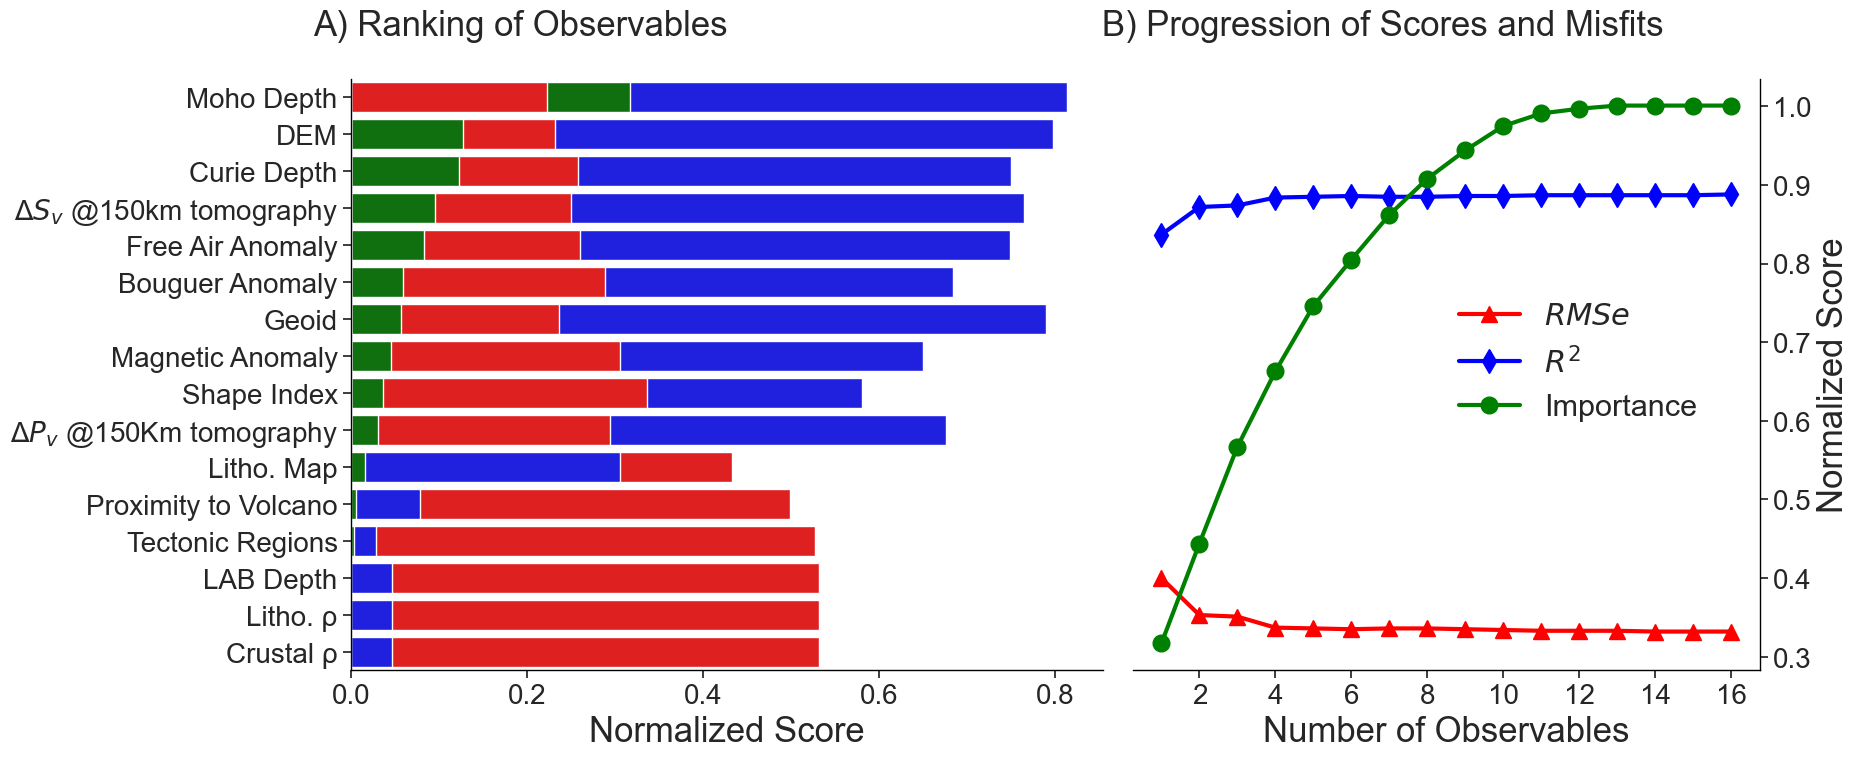

In [30]:
#Create a figure with 2 subplots
plt.rcParams.update(plt_params)
fig, axes = plt.subplots(1,2, figsize=(19,8), gridspec_kw={'width_ratios': [3, 2.5]})
axes.ravel()

# Define plotting function
def plot_observables_importance(condition, x_value, label, color, ax):
    if condition.any():
        sns.barplot(x = observables_importance_df[x_value].values * condition.astype(int).values,
                    y = observables_importance_df.index,
                    ax=ax, color=color, label=label)

# Plot 1: Mask_RI_NRMSE
plot_observables_importance(high_RI_low_NRMSE, 'CD', 'Relative Importance', 'blue', axes[0])
plot_observables_importance(high_RI_low_NRMSE, 'NRMSe', 'NRMSe', 'red', axes[0])
plot_observables_importance(high_RI_low_NRMSE, 'RI', 'Relative Importance', 'green', axes[0])

# Plot 2: Mask_NRMSE_RI
plot_observables_importance(low_RI_high_NRMSE, 'CD', 'Relative Importance', 'blue', axes[0])
plot_observables_importance(low_RI_high_NRMSE, 'RI', 'Relative Importance', 'green', axes[0])
plot_observables_importance(low_RI_high_NRMSE, 'NRMSe', 'NRMSe', 'red', axes[0])

# Plot 3: Mask_CD_RI
plot_observables_importance(low_RI_high_CD, 'NRMSe', 'NRMSe', 'red', axes[0])
plot_observables_importance(low_RI_high_CD, 'RI', 'Relative Importance', 'green', axes[0])
plot_observables_importance(low_RI_high_CD, 'CD', 'CD', 'blue', axes[0])


# Plot 4: Mask_RI_CD
plot_observables_importance(high_RI_low_CD, 'NRMSe', 'NRMSe', 'red', axes[0])
plot_observables_importance(high_RI_low_CD, 'CD', 'CD', 'blue', axes[0])
plot_observables_importance(high_RI_low_CD, 'RI', 'Relative Importance', 'green', axes[0])


# Plot feature importance for each metric if there are any important features
plot_observables_importance(low_CD_high_NRMSE, 'CD', 'CD', 'blue', axes[0])
plot_observables_importance(low_CD_high_NRMSE, 'RI', 'Relative Importance', 'green', axes[0])
plot_observables_importance(low_CD_high_NRMSE, 'NRMSe', 'NRMSe', 'red', axes[0])


# Plot feature importance for CD and relative importance if there are any important features
plot_observables_importance(no_criteria_met, 'NRMSe', 'NRMSe', 'red', axes[0])
plot_observables_importance(no_criteria_met, 'RI', 'Relative Importance', 'green', axes[0])
plot_observables_importance(no_criteria_met, 'CD', 'CD', 'blue', axes[0])

    
# Set labels and styles for the first subplot
axes[0].set_ylabel('')
axes[0].grid(False)
axes[0].spines.right.set_visible(False)
axes[0].spines.top.set_visible(False)
axes[0].yaxis.set_ticks_position('left')
axes[0].xaxis.set_ticks_position('bottom')
axes[0].locator_params(axis='x', nbins=7)
axes[0].set_title(f'{sub_figs[0]}) Ranking of Observables', loc ='left', pad=10, size=25, x=-0.05, y=1.05)
axes[0].set_xlabel("Normalized Score")

#########


# Define the size of markers and lines
marker_size = 12
line_width = 3

# Plot the score progression_importance_df for NRMSe
axes[1].plot(progression_importance_df.index, progression_importance_df['RMSe'], color='red', linewidth=line_width,
             marker="^", label='$RMSe$', markersize=marker_size)

# Plot the score progression_importance_df for CD
axes[1].plot(progression_importance_df.index, progression_importance_df['CD'], color='blue', linewidth=line_width, 
             marker="d",  label='$R^2$', markersize=marker_size)

# Plot the cumulative sum of feature importances
axes[1].plot(progression_importance_df.index, progression_importance_df['CUMSUM'], linewidth=line_width, 
             color='green',  marker="o", label='Importance', markersize=marker_size)

# Set the axis labels and legend
axes[1].set(xlabel="Number of Observables", ylabel="Normalized Score")
axes[1].legend(loc=[0.5, 0.4], frameon=False, fontsize=22) #legend
axes[1].set_title(f'{sub_figs[1]}) Progression of Scores and Misfits', loc ='left', pad=10, size=25,  x=-0.05, y=1.05)

# Set the number of tick marks and turn off the grid
axes[1].locator_params(axis='y', nbins=10)
axes[1].locator_params(axis='x', nbins=9)
axes[1].grid(False)

# Turn off the top and right spines and only show ticks on the left and bottom spines
for spine in ["right", "top"]:
    axes[1].spines[spine].set_visible(False)
axes[1].yaxis.set_ticks_position('left')
axes[1].xaxis.set_ticks_position('bottom')

# Shift the y-axis to the right
axes[1].spines['left'].set_visible(False)
axes[1].spines['right'].set_visible(True)
axes[1].yaxis.tick_right()

# Set the labels for the y-axis on the right side
axes[1].yaxis.set_label_position('right')

# Adjust the spacing of the plot
plt.tight_layout()


# Save Figure
#fig.savefig(DIR/'fig'/"fig_5.pdf", dpi=1200, format='pdf', bbox_inches='tight')
fig.savefig(DIR/'fig'/"6_Contribution_Importance_ra.png", bbox_inches='tight', dpi=500 )

In [ ]:
# Create a figure with 2 subplots
plt.rcParams.update(plt_params)
fig, axes = plt.subplots(1,2, figsize=(19,8), gridspec_kw={'width_ratios': [3, 2.5]})
axes.ravel()

# Define plotting function
def plot_observables_importance(condition, x_value, label, color, ax):
    if condition.any():
        sns.barplot(x = observables_importance_df[x_value].values * condition.astype(int).values,
                    y = observables_importance_df.index,
                    ax=ax, color=color, label=label)

# Plot 1: Mask_RI_NRMSE
plot_observables_importance(high_RI_low_NRMSE, 'CD', 'Relative Importance', 'blue', axes[0])
plot_observables_importance(high_RI_low_NRMSE, 'NRMSe', 'NRMSe', 'red', axes[0])
plot_observables_importance(high_RI_low_NRMSE, 'RI', 'Relative Importance', 'green', axes[0])

# Plot 2: Mask_NRMSE_RI
plot_observables_importance(low_RI_high_NRMSE, 'CD', 'Relative Importance', 'blue', axes[0])
plot_observables_importance(low_RI_high_NRMSE, 'RI', 'Relative Importance', 'red', axes[0])
plot_observables_importance(low_RI_high_NRMSE, 'NRMSe', 'NRMSe', 'green', axes[0])

# Plot 3: Mask_CD_RI
plot_observables_importance(low_RI_high_CD, 'NRMSe', 'NRMSe', 'red', axes[0])
plot_observables_importance(low_RI_high_CD, 'RI', 'Relative Importance', 'green', axes[0])
plot_observables_importance(low_RI_high_CD, 'CD', 'CD', 'blue', axes[0])


# Plot 4: Mask_RI_CD
plot_observables_importance(high_RI_low_CD, 'NRMSe', 'NRMSe', 'red', axes[0])
plot_observables_importance(high_RI_low_CD, 'CD', 'CD', 'blue', axes[0])
plot_observables_importance(high_RI_low_CD, 'RI', 'Relative Importance', 'green', axes[0])


# Plot feature importance for each metric if there are any important features
plot_observables_importance(low_CD_high_NRMSE, 'CD', 'CD', 'blue', axes[0])
plot_observables_importance(low_CD_high_NRMSE, 'RI', 'Relative Importance', 'green', axes[0])
plot_observables_importance(low_CD_high_NRMSE, 'NRMSe', 'NRMSe', 'red', axes[0])


# Plot feature importance for CD and relative importance if there are any important features
plot_observables_importance(no_criteria_met, 'NRMSe', 'NRMSe', 'red', axes[0])
plot_observables_importance(no_criteria_met, 'RI', 'Relative Importance', 'green', axes[0])
plot_observables_importance(no_criteria_met, 'CD', 'CD', 'blue', axes[0])

    
# Set labels and styles for the first subplot
axes[0].set_ylabel('')
axes[0].grid(False)
axes[0].spines.right.set_visible(False)
axes[0].spines.top.set_visible(False)
axes[0].yaxis.set_ticks_position('left')
axes[0].xaxis.set_ticks_position('bottom')
axes[0].locator_params(axis='x', nbins=7)
axes[0].set_title(f'{sub_figs[0]}) Ranking of Observables', loc ='left', pad=10, size=25, x=-0.05, y=1.05)
axes[0].set_xlabel("Normalized Score")

#########


# Define the size of markers and lines
marker_size = 12
line_width = 3

# Plot the score progression_importance_df for NRMSe
axes[1].plot(progression_importance_df.index, progression_importance_df['RMSe'], color='red', linewidth=line_width,
             marker="^", label='$RMSe$', markersize=marker_size)

# Plot the score progression_importance_df for CD
axes[1].plot(progression_importance_df.index, progression_importance_df['CD'], color='blue', linewidth=line_width, 
             marker="d",  label='$R^2$', markersize=marker_size)

# Plot the cumulative sum of feature importances
axes[1].plot(progression_importance_df.index, progression_importance_df['CUMSUM'], linewidth=line_width, 
             color='green',  marker="o", label='Importance', markersize=marker_size)

# Set the axis labels and legend
axes[1].set(xlabel="Number of Observables", ylabel="Normalized Score")
axes[1].legend(loc=[.45, .08], frameon=False, fontsize=22)
axes[1].set_title(f'{sub_figs[1]}) Progression of Scores and Misfits', loc ='left', pad=10, size=25,  x=-0.05, y=1.05)

# Set the number of tick marks and turn off the grid
axes[1].locator_params(axis='y', nbins=10)
axes[1].locator_params(axis='x', nbins=9)
axes[1].grid(False)

# Turn off the top and right spines and only show ticks on the left and bottom spines
for spine in ["right", "top"]:
    axes[1].spines[spine].set_visible(False)
axes[1].yaxis.set_ticks_position('left')
axes[1].xaxis.set_ticks_position('bottom')

# Shift the y-axis to the right
axes[1].spines['left'].set_visible(False)
axes[1].spines['right'].set_visible(True)
axes[1].yaxis.tick_right()

# Set the labels for the y-axis on the right side
axes[1].yaxis.set_label_position('right')

# Adjust the spacing of the plot
plt.tight_layout()


# Save Figure
#fig.savefig(dir_p/'fig'/'presentation'/"fig_p6d.jpeg", bbox_inches='tight', dpi=300 )
#fig.savefig(DIR/'fig'/"fig_5.pdf", dpi=1200, format='pdf', bbox_inches='tight')
fig.savefig(DIR/'fig'/"7_Contribution_Importance_ra", bbox_inches='tight', dpi=500 )

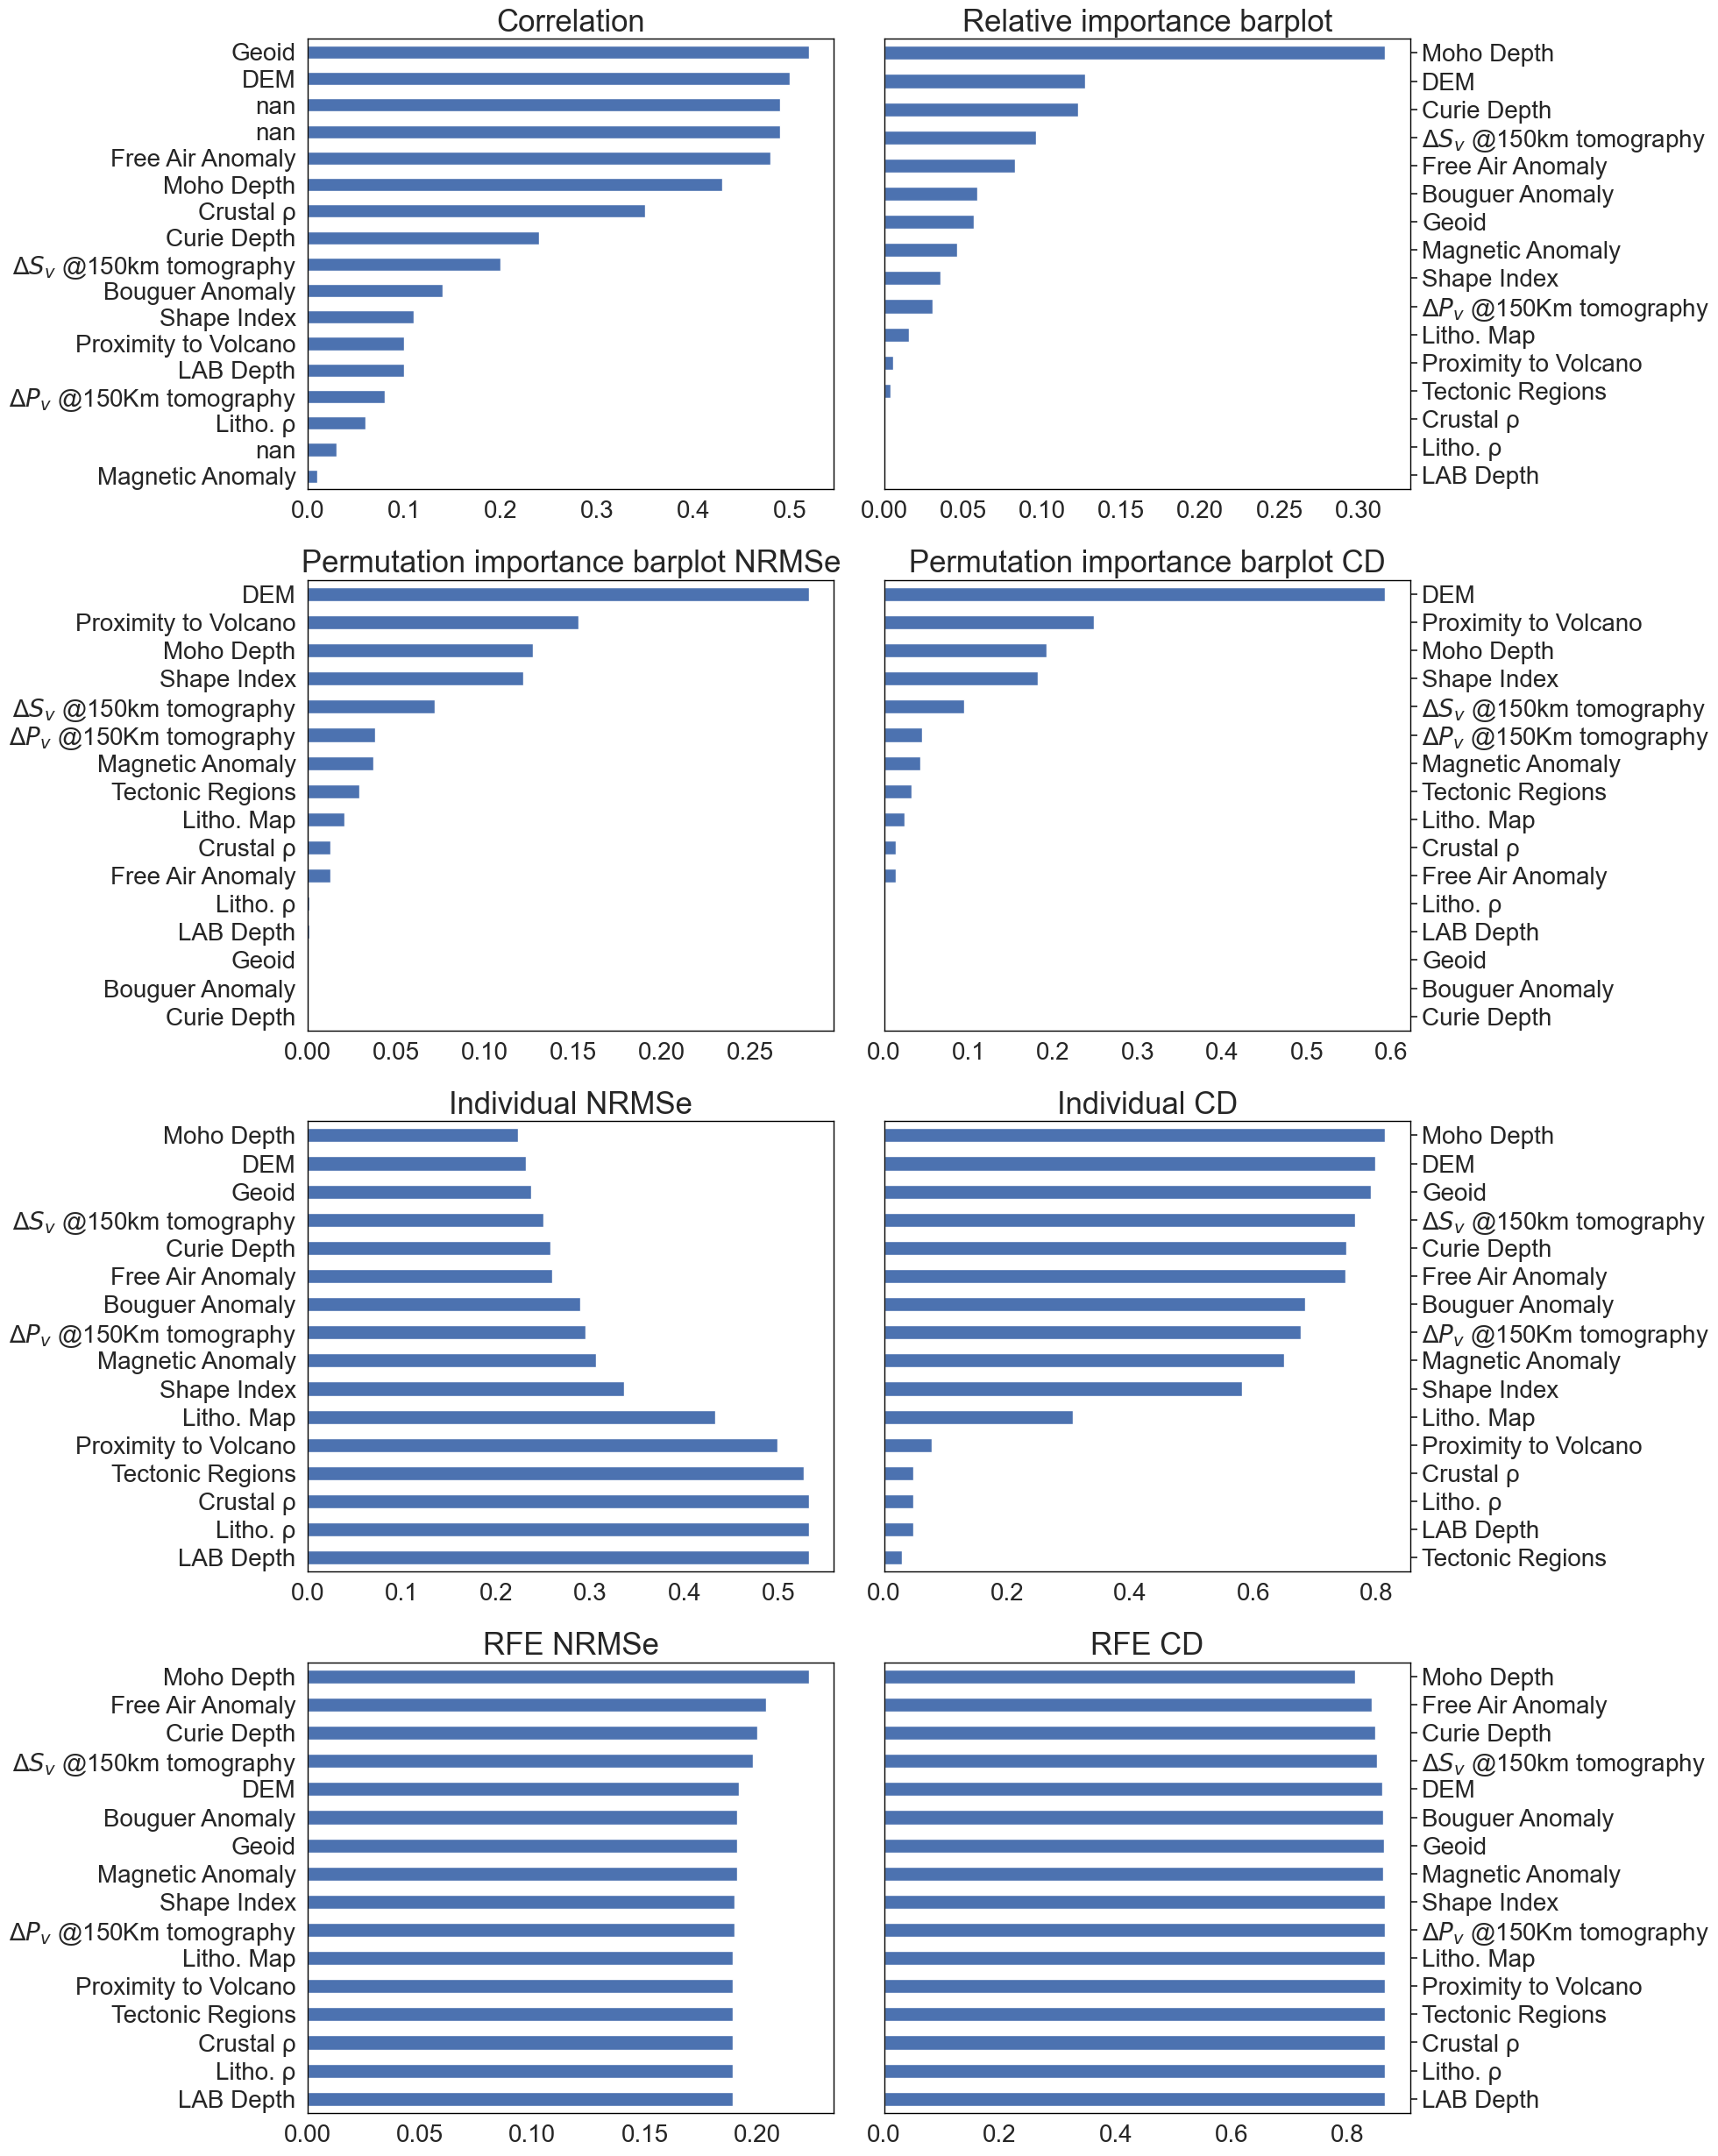

In [31]:
plt.rcParams.update(plt_params)
# Set figure size and create subplots
fig, axes = plt.subplots(4, 2, figsize=(20, 25))

axes = axes.flatten()
# Update plot parameters

###correlation
if ('REG' in ghf_df.columns) or ('GILM' in ghf_df.columns):
    ghf_df = ghf_df.drop('REG', axis=1)
    ghf_df = ghf_df.drop('GLIM', axis=1)

numeric_columns = ghf_df.select_dtypes(include=np.number).columns
corr = ghf_df[numeric_columns].corr().abs().round(2)
#corr = ghf_df.corr().abs().round(2)
corr.drop(TARGET, inplace=True)

corr_tmp = corr[[TARGET]]
corr_tmp['LABELS'] = obs_df['LABELS']

corr_tmp = corr_tmp.sort_values(by=TARGET, ascending=False).set_index('LABELS')

# Plot the permutation feature importance scores as a boxplot
corr_tmp[[TARGET]].sort_values(by=TARGET, ascending=True).plot.barh(ax=axes[0], legend=False)
axes[0].set_title('Correlation')
axes[0].set_ylabel('')

# Sort the feature importance DataFrame by random forest feature importance and plot it
observables_importance_df.sort_values(by="RI", ascending=True).plot.barh(ax=axes[1], y='RI', legend=False)
axes[1].set_title('Relative importance barplot')
axes[1].set_ylabel('')
axes[1].tick_params(axis='y', labelright=True, labelleft=False, right=True, left=False)


# Sort the feature importance DataFrame by permutation feature importance and plot it
observables_importance_df.sort_values(by="PFI_NRMSe", ascending=True).plot.barh(ax=axes[2], y='PFI_NRMSe', legend=False)
axes[2].set_title('Permutation importance barplot NRMSe')
axes[2].set_ylabel('')


# Sort the feature importance DataFrame by permutation feature importance and plot it
observables_importance_df.sort_values(by="PFI_CD", ascending=True).plot.barh(ax=axes[3], y='PFI_CD', legend=False)
axes[3].set_title('Permutation importance barplot CD')
axes[3].set_ylabel('')
axes[3].tick_params(axis='y', labelright=True, labelleft=False, right=True, left=False)


# Plot the permutation feature importance scores as a boxplot
observables_importance_df.sort_values(by="NRMSe", ascending=False).plot.barh(ax=axes[4], y='NRMSe', legend=False)
axes[4].set_title('Individual NRMSe')
axes[4].set_ylabel('')
#axes[3].set_xlim(left=0.36)

# Plot the permutation feature importance scores as a boxplot
observables_importance_df.sort_values(by="CD", ascending=True).plot.barh(ax=axes[5], y='CD', legend=False)
axes[5].set_title('Individual CD')
axes[5].set_ylabel('')
#axes[4].set_xlim(left=0.09)
axes[5].tick_params(axis='y', labelright=True, labelleft=False, right=True, left=False)


# Plot the permutation feature importance scores as a boxplot
observables_importance_df.sort_values(by="RANKING", ascending=False).plot.barh(ax=axes[6], y='RFE_NRMSe', legend=False)
axes[6].set_title('RFE NRMSe')
axes[6].set_ylabel('')
#axes[3].set_xlim(left=0.36)

# Plot the permutation feature importance scores as a boxplot
observables_importance_df.sort_values(by="RANKING", ascending=False).plot.barh(ax=axes[7], y='RFE_CD', legend=False)
axes[7].set_title('RFE CD')
axes[7].set_ylabel('')
#axes[4].set_xlim(left=0.09)
axes[7].tick_params(axis='y', labelright=True, labelleft=False, right=True, left=False)



# Adjust the layout of the subplots
plt.tight_layout()

# Show the plot
fig.savefig(DIR/'fig'/"6_Contribution_Importance2.png", bbox_inches='tight', dpi=500 )
plt.show()

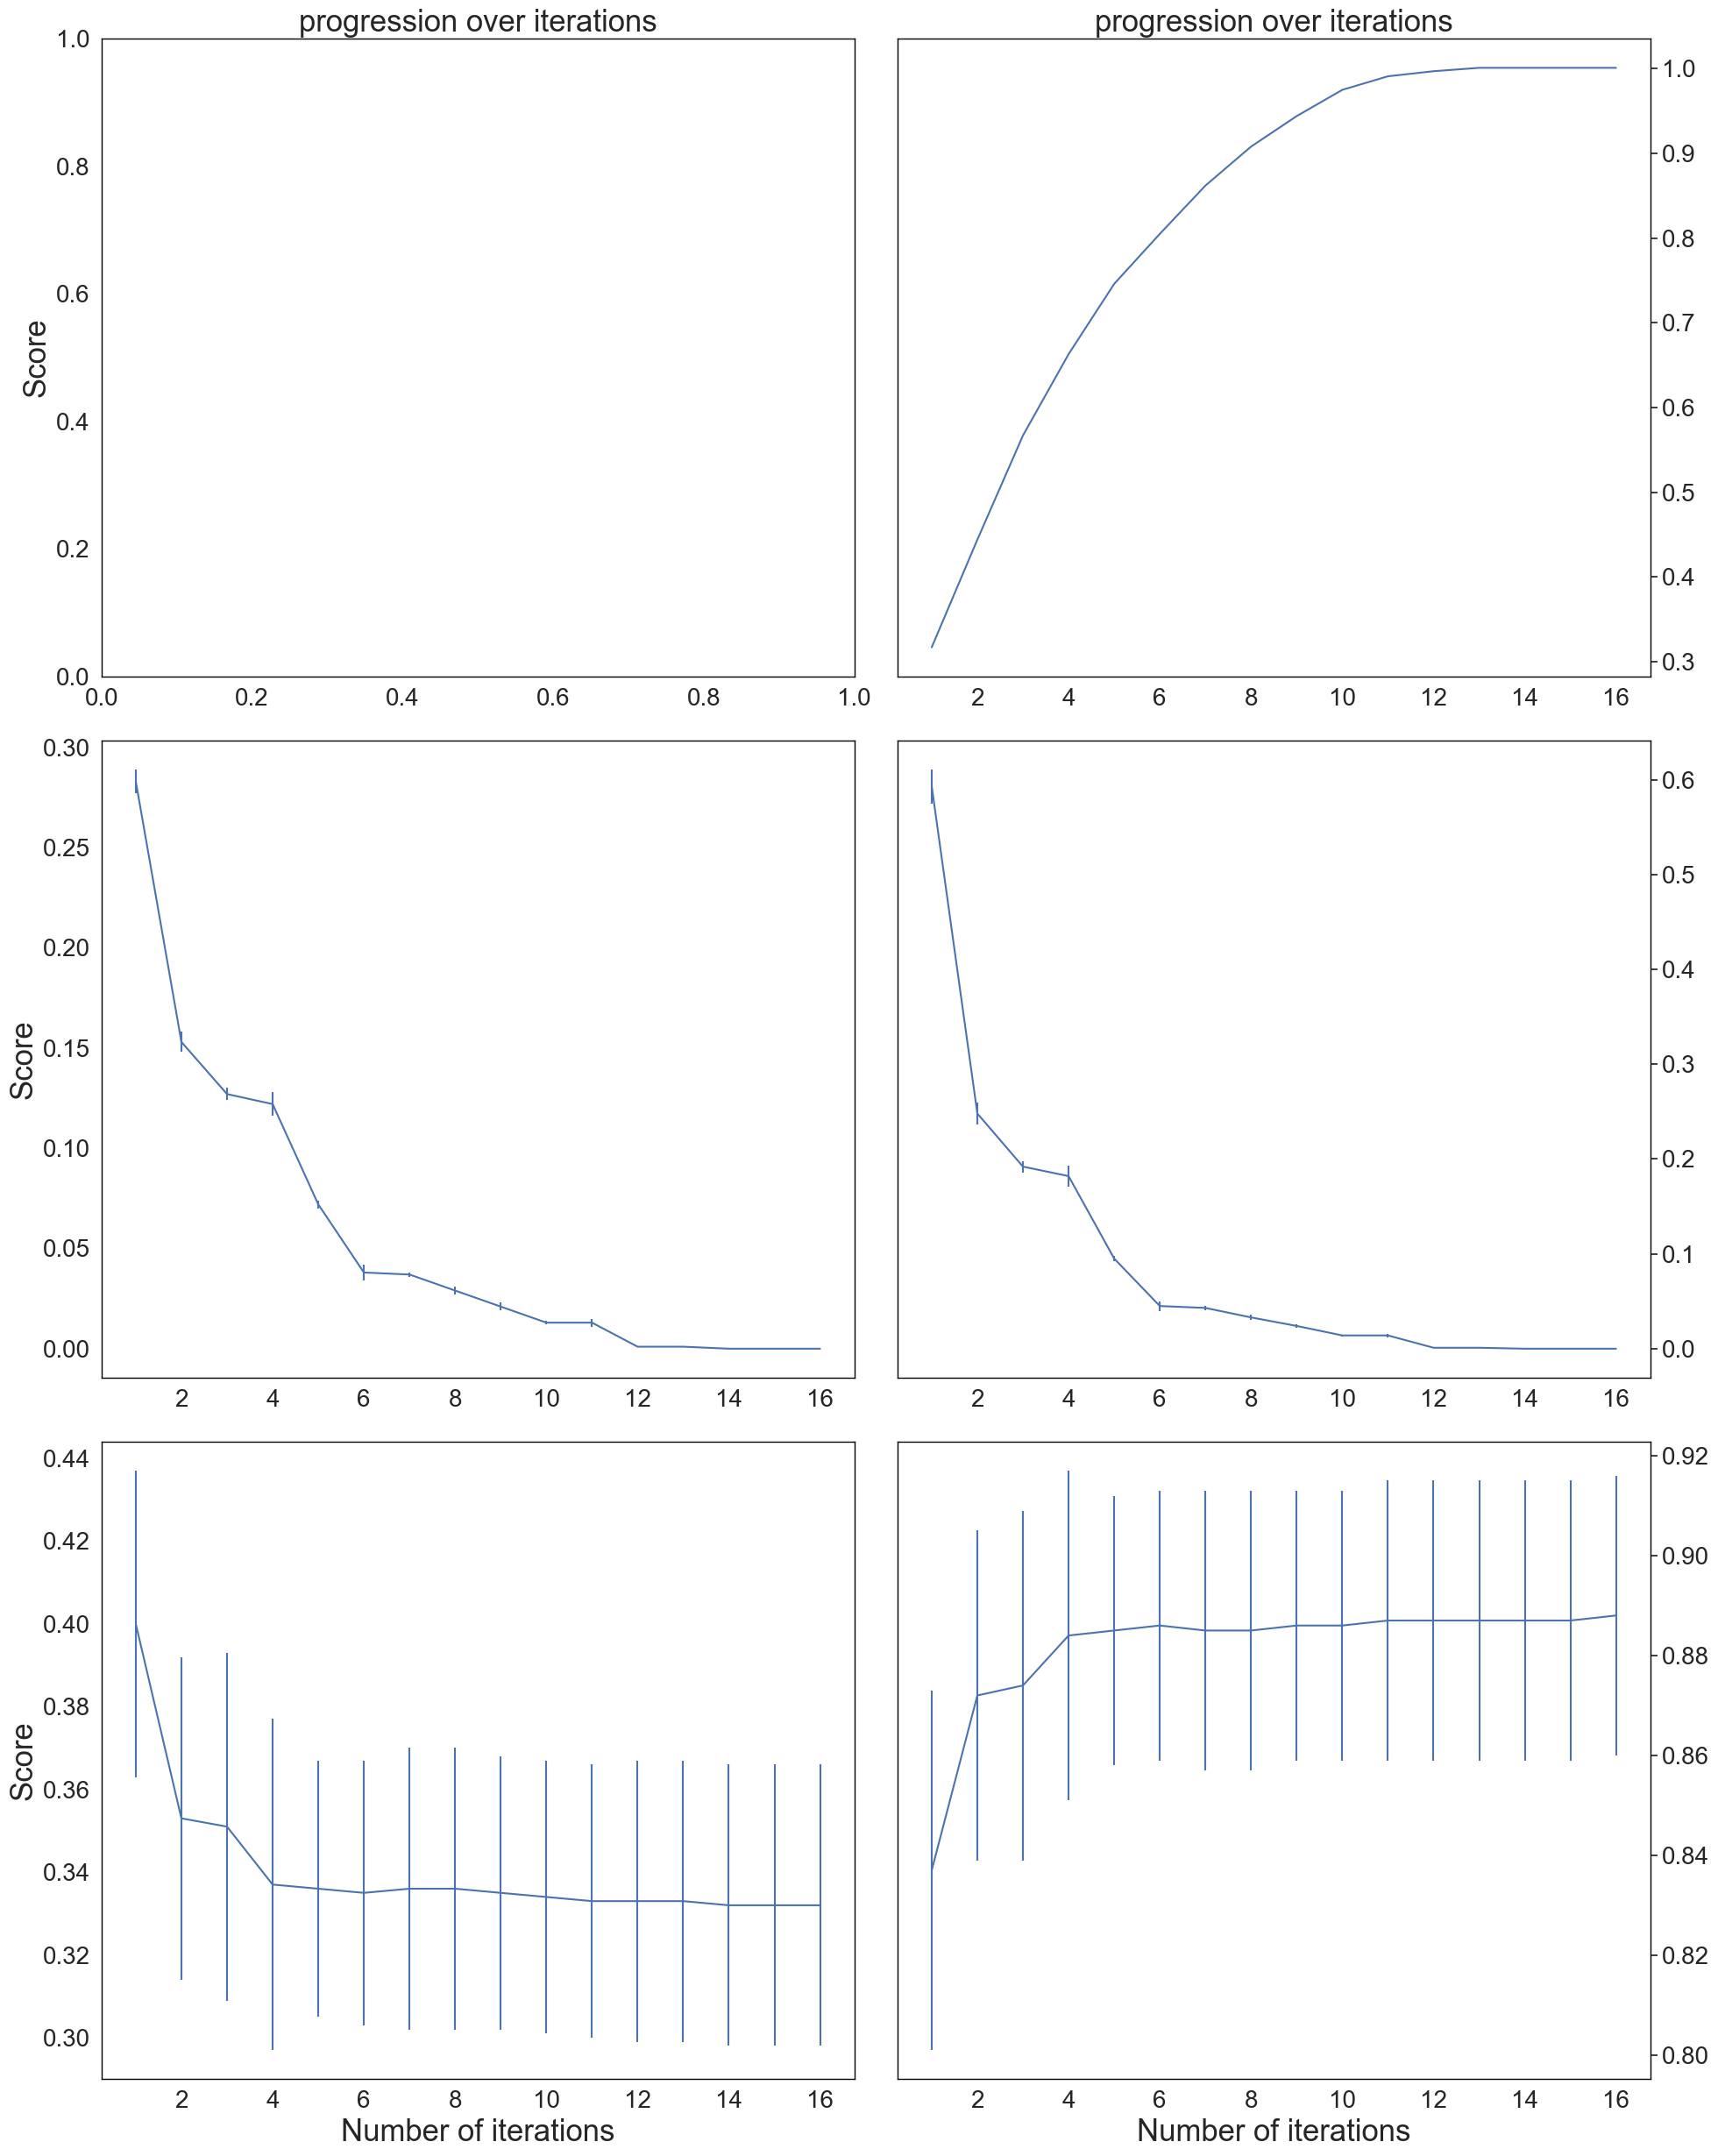

In [32]:
n_scores = len(observables_lst)
fig, axes = plt.subplots(3, 2, figsize=(20, 25))

axes = axes.flatten()
# Plot 1
axes[1].errorbar(
    range(1, n_scores + 1),
    observables_importance_df["RI"].sort_values(ascending=False).cumsum(),
)

axes[1].tick_params(axis='y', labelright=True, labelleft=False, right=True, left=False)


axes[2].errorbar(
    range(1, n_scores + 1),
    observables_importance_df.sort_values(by="PFI_NRMSe", ascending=False)["PFI_NRMSe"],
    yerr=observables_importance_df.sort_values(by="PFI_NRMSe", ascending=False)["PFI_NRMSe_std"],
)

axes[3].errorbar(
    range(1, n_scores + 1),
    observables_importance_df.sort_values(by="PFI_CD", ascending=False)["PFI_CD"],
    yerr=observables_importance_df.sort_values(by="PFI_CD", ascending=False)["PFI_CD_std"],
)

axes[3].tick_params(axis='y', labelright=True, labelleft=False, right=True, left=False)


axes[4].errorbar(
    range(1, n_scores + 1),
    progression_importance_df['RMSe'],
    yerr=progression_importance_df["RMSe_std"],
    #progression_importance_df['RMSe'],
    #yerr=progression_importance_df["RMSe_std"],
)


axes[5].errorbar(
    range(1, n_scores + 1),
    progression_importance_df['CD'],
    yerr=progression_importance_df["CD_std"],
)

axes[5].tick_params(axis='y', labelright=True, labelleft=False, right=True, left=False)



axes[0].set_title("progression over iterations")
axes[1].set_title("progression over iterations")

axes[4].set_xlabel("Number of iterations")
axes[5].set_xlabel("Number of iterations")
axes[0].set_ylabel("Score")
axes[2].set_ylabel("Score")
axes[4].set_ylabel("Score")


# Adjust the layout of the subplots
plt.tight_layout()

# Show the plot
fig.savefig(DIR/'fig'/"6_Contribution_Importance3.png", bbox_inches='tight', dpi=500 )
plt.show()


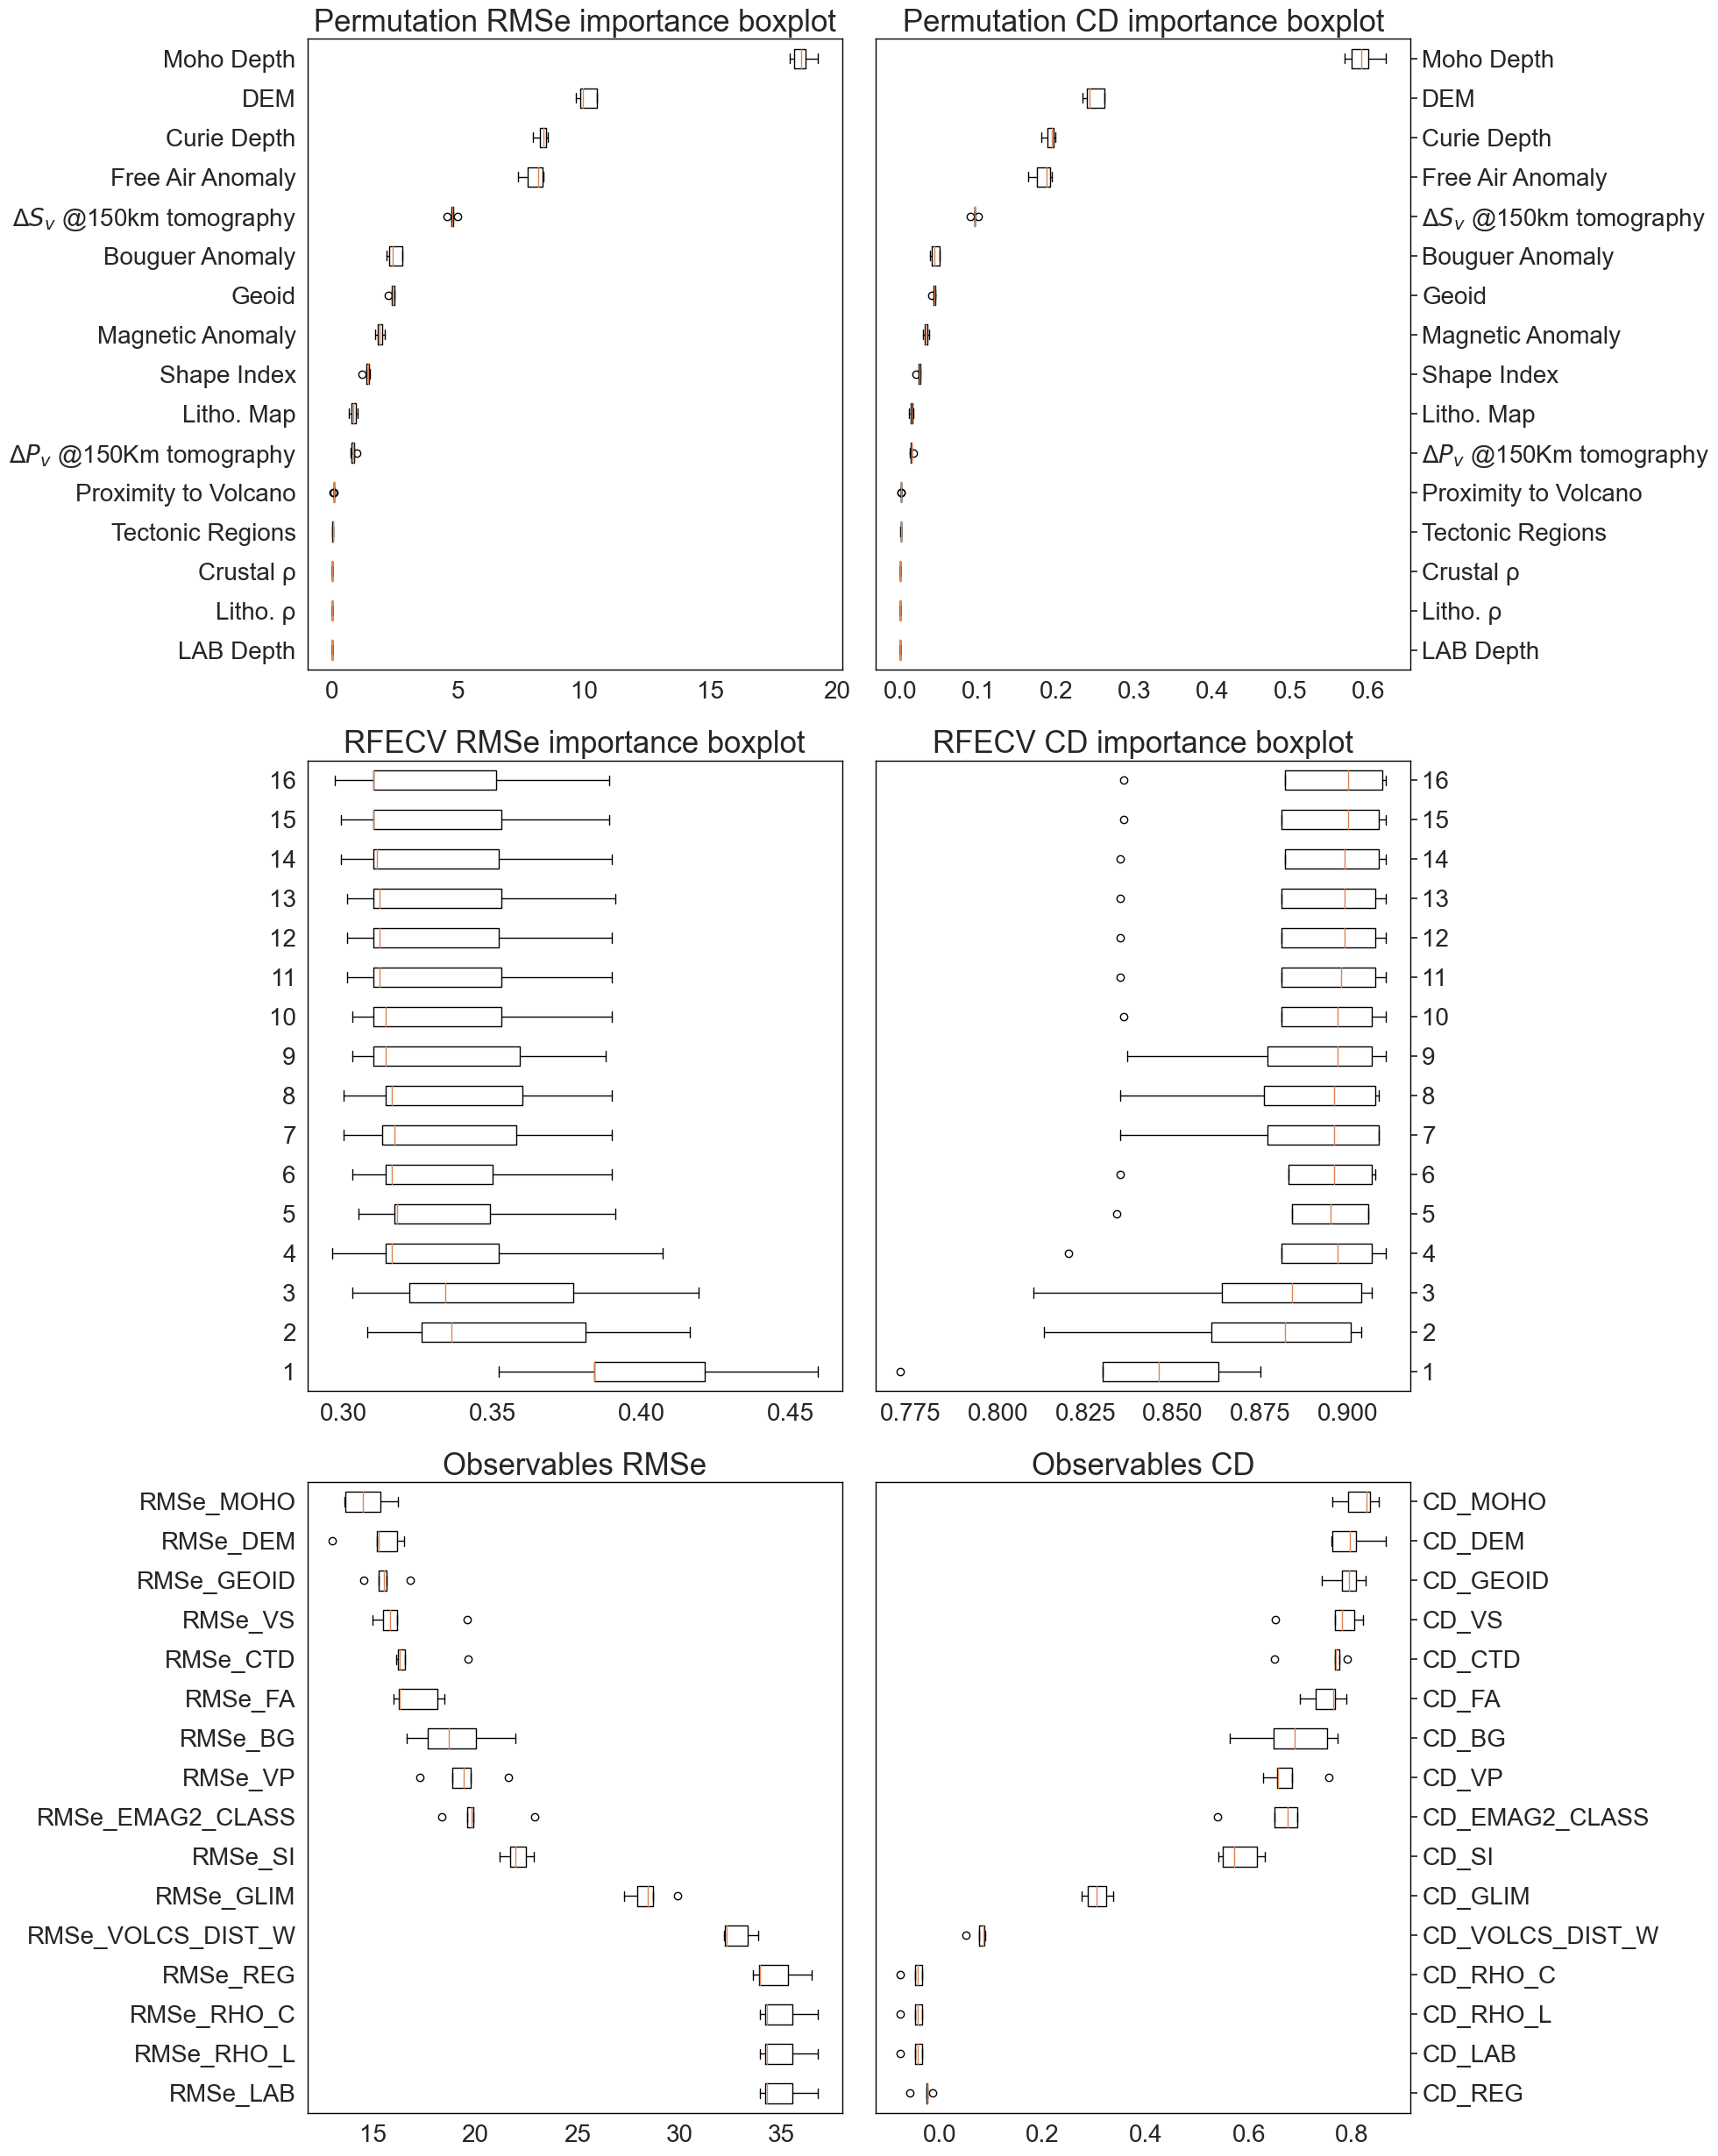

In [33]:
n_scores = len(observables_lst)
fig, axes = plt.subplots(3, 2, figsize=(20, 25))

axes = axes.flatten()
# Plot 1

# Plot the permutation feature importance scores as a boxplot
axes[0].boxplot(
    #permutations_importance_dict.importances[PERMUTATION_RANKING.importances_mean.argsort()].T,
    permutations_importance_dict['RMSe'].abs().T[permutations_importance_dict['RMSe'].abs().mean(1).argsort()],

    vert=False,
    labels=obs_df.iloc[permutations_importance_dict['RMSe'].abs().mean(1).argsort() , 1].values,
)
axes[0].set_title('Permutation RMSe importance boxplot')

axes[1].boxplot(
    #permutations_importance_dict.importances[PERMUTATION_RANKING.importances_mean.argsort()].T,
    permutations_importance_dict['CD'].abs().T[permutations_importance_dict['CD'].abs().mean(1).argsort()],

    vert=False,
    labels=obs_df.iloc[permutations_importance_dict['CD'].abs().mean(1).argsort() , 1].values,
)
axes[1].set_title('Permutation CD importance boxplot')
# Set the y-axis tick parameters
axes[1].tick_params(axis='y', labelright=True, labelleft=False, right=True, left=False)



# Plot the permutation feature importance scores as a boxplot
axes[2].boxplot(
    #permutations_importance_dict.importances[PERMUTATION_RANKING.importances_mean.argsort()].T,
    rfecv_dict['RMSe'].T.iloc[2:, :],

    vert=False,
    #labels=obs_df.iloc[permutations_importance_dict['RMSE'].abs().mean(1).argsort() , 1].values,
)
axes[2].set_title('RFECV RMSe importance boxplot')

axes[3].boxplot(
    #permutations_importance_dict.importances[PERMUTATION_RANKING.importances_mean.argsort()].T,
    rfecv_dict['CD'].T.iloc[2:, :],

    vert=False,
    #labels=obs_df.iloc[permutations_importance_dict['CD'].abs().mean(1).argsort() , 1].values,
)
axes[3].set_title('RFECV CD importance boxplot')
axes[3].tick_params(axis='y', labelright=True, labelleft=False, right=True, left=False)


observables_df = pd.DataFrame(observables_dict)
observables_rmse_lst = [key for key in observables_dict.keys() if 'RMSe' in key]
observables_cd_lst = [key for key in observables_dict.keys() if 'CD' in key]


axes[4].boxplot(
    #permutations_importance_dict.importances[PERMUTATION_RANKING.importances_mean.argsort()].T,
    observables_df.loc[:, observables_df[observables_rmse_lst].abs().mean().sort_values(ascending=False).index],
    vert=False,
    labels=observables_df[observables_rmse_lst].abs().mean().sort_values(ascending=False).index,
)
axes[4].set_title('Observables RMSe')

axes[5].boxplot(
    #permutations_importance_dict.importances[PERMUTATION_RANKING.importances_mean.argsort()].T,
    observables_df.loc[:, observables_df[observables_cd_lst].abs().mean().sort_values(ascending=True).index],
    vert=False,
    labels=observables_df[observables_cd_lst].abs().mean().sort_values(ascending=True).index,
)
axes[5].set_title('Observables CD')
axes[5].tick_params(axis='y', labelright=True, labelleft=False, right=True, left=False)



# Adjust the layout of the subplots
plt.tight_layout()

# Show the plot
fig.savefig(DIR/'fig'/"6_Contribution_Importance4.png", bbox_inches='tight', dpi=500 )
plt.show()


# Modeling

In [34]:
# this line will predict the GHF with 16 models starting from the higher RI, so the optimum is which one with all observables exclude the lower in ri
#optimum is number 12
#exclude the lowest rank observables 

In [35]:
pipeline_dict = {}
observables_n_lst = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16']

grid_g_nn = (len(grid_g_xr.Y), len(grid_g_xr.X))

for observbale_idx, observable_n in tqdm_notebook(enumerate(observables_n_lst), 
                                                  total=len(observables_n_lst), desc='Training: '):    
    
    # Sort OBSERVABLE_IMPORTANCE dataframe by 'RI' column in descending order
    # Get top 'best_feature' features based on the ranking
    observables_chosen = observables_importance_df.sort_values(by="RI", ascending=False)['REF_CODE_TRANS'].values[:observbale_idx+1]
        
    logging.info(f'{observable_n} {observables_chosen} fitting')

    regressor = ensemble.RandomForestRegressor(random_state=RANDOM_STATE)


    steps_lst=[("preprocessor", preprocessor), 
           #("regressor", regressor), 
           ('ttr', compose.TransformedTargetRegressor(regressor=regressor, 
                                                      transformer=numeric_transformer_target))
          ]


    # Initialize Pipeline object
    pipeline_fnt = pipeline.Pipeline(steps=steps_lst)
    pipeline_fnt.set_params(**tuned_hyperparameters)
      
    # Fit the pipeline on the reduced set of features and target variable
    pipeline_fnt.fit(X[observables_chosen], y)
    
    # predict the HF value for each grid point in A_grid
    grid_g_xr[f"PRED_{observable_n}"] = (('Y', 'X'),  pipeline_fnt.predict(grid_g_df[observables_chosen]).reshape(-1).reshape(grid_g_nn))
           
    pipeline_dict[observable_n] = pipeline_fnt
    
    logging.info(f'Terminated')

print('terminated')

Training:   0%|          | 0/16 [00:00<?, ?it/s]

2024-08-02 00:10:29,342 - INFO - 01 ['MOHO'] fitting
2024-08-02 00:10:35,068 - INFO - Terminated
2024-08-02 00:10:35,071 - INFO - 02 ['MOHO' 'DEM'] fitting
2024-08-02 00:10:40,780 - INFO - Terminated
2024-08-02 00:10:40,783 - INFO - 03 ['MOHO' 'DEM' 'CTD'] fitting
2024-08-02 00:10:48,240 - INFO - Terminated
2024-08-02 00:10:48,242 - INFO - 04 ['MOHO' 'DEM' 'CTD' 'VS'] fitting
2024-08-02 00:10:57,897 - INFO - Terminated
2024-08-02 00:10:57,900 - INFO - 05 ['MOHO' 'DEM' 'CTD' 'VS' 'FA'] fitting
2024-08-02 00:11:08,240 - INFO - Terminated
2024-08-02 00:11:08,242 - INFO - 06 ['MOHO' 'DEM' 'CTD' 'VS' 'FA' 'BG'] fitting
2024-08-02 00:11:19,301 - INFO - Terminated
2024-08-02 00:11:19,304 - INFO - 07 ['MOHO' 'DEM' 'CTD' 'VS' 'FA' 'BG' 'GEOID'] fitting
2024-08-02 00:11:31,749 - INFO - Terminated
2024-08-02 00:11:31,752 - INFO - 08 ['MOHO' 'DEM' 'CTD' 'VS' 'FA' 'BG' 'GEOID' 'EMAG2_CLASS'] fitting
2024-08-02 00:11:46,598 - INFO - Terminated
2024-08-02 00:11:46,601 - INFO - 09 ['MOHO' 'DEM' 'CTD' 

terminated


### Quantile modeling

In [36]:
#change this line according to your importances
optimal_observables_n = '12'

# Access the estimators of the 'ttr' regressor in the pipeline_dict
estimators = pipeline_dict[optimal_observables_n]['ttr'].regressor_.estimators_

# Get the number of estimators
n_estimators = tuned_hyperparameters['ttr__regressor__n_estimators']

# Get the observables chosen based on their importance
observables_chosen = observables_importance_df.sort_values(by="RI", ascending=False)['REF_CODE_TRANS'].values[:int(optimal_observables_n)]

# Create labels for the estimators
estimators_labels = []
for i in range(1, n_estimators+1):
    estimators_labels.append(str(i).zfill(3))

# Iterate over the estimators
for i in tqdm_notebook(range(n_estimators), desc='Quantile Modelling: '):
    pipeline_estimator = pipeline_dict[optimal_observables_n]['ttr'].regressor_.estimators_[i]
    pipeline_transformer = pipeline_dict[optimal_observables_n]['ttr'].transformer_
    
    # Predict using the current estimator and transform the predictions back to original scale
    predictions = pipeline_estimator.predict(grid_g_df[observables_chosen]).reshape(-1, 1)
    predictions_trans = pipeline_transformer.inverse_transform(predictions)
    
    # Add the predictions to the grid_g_xr dataset with corresponding estimator label
    grid_g_xr[estimators_labels[i]] = (('Y', 'X'), predictions_trans.reshape(grid_g_nn))

# Compute the average, median, and standard deviation of the predictions across all estimators
grid_g_xr[f'Q_AVG_{optimal_observables_n}'] = (('Y', 'X'), grid_g_xr[estimators_labels].to_array().mean(axis=0).values)
grid_g_xr[f'Q_MD_{optimal_observables_n}'] = (('Y', 'X'), grid_g_xr[estimators_labels].to_array().median(axis=0).values)
grid_g_xr[f'Q_STD_{optimal_observables_n}'] = (('Y', 'X'), grid_g_xr[estimators_labels].to_array().std(axis=0).values)


Quantile Modelling:   0%|          | 0/880 [00:00<?, ?it/s]

### Differences

In [37]:
# Create a list of prediction labels
prediction_labels = [f"PRED_{prediction}" for prediction in observables_n_lst[3:]]

# Loop through the list of keys
for observable_n in tqdm_notebook(observables_n_lst, desc='Differencing: '):
    # Calculate the difference between 'RFE_16' and the current key
    grid_g_xr[f'Diff_12_{observable_n}'] = grid_g_xr[f"PRED_{optimal_observables_n}"] - grid_g_xr[f'PRED_{observable_n}']
    # Print the mean difference rounded to two decimal places
    print(f"Difference between 12 and {observable_n}: {np.round(grid_g_xr[f'Diff_12_{observable_n}'].values.mean(), 2)}")

# Compute maximum, minimum, range, and relative standard deviation
grid_g_xr['MAX'] = grid_g_xr[prediction_labels].to_array().max(axis=0)
grid_g_xr['MIN'] = grid_g_xr[prediction_labels].to_array().min(axis=0)
grid_g_xr['RAN'] = (grid_g_xr['MAX'] - grid_g_xr['MIN']) / 2
grid_g_xr['RSD'] = xr.apply_ufunc(coefficient_variation, grid_g_xr[f"PRED_{optimal_observables_n}"])

Differencing:   0%|          | 0/16 [00:00<?, ?it/s]

Difference between 12 and 01: -4.55
Difference between 12 and 02: 1.4
Difference between 12 and 03: 1.93
Difference between 12 and 04: 1.59
Difference between 12 and 05: 0.84
Difference between 12 and 06: -0.63
Difference between 12 and 07: 0.92
Difference between 12 and 08: 1.36
Difference between 12 and 09: -0.11
Difference between 12 and 10: -0.41
Difference between 12 and 11: -0.06
Difference between 12 and 12: 0.0
Difference between 12 and 13: 0.0
Difference between 12 and 14: 0.29
Difference between 12 and 15: 0.35
Difference between 12 and 16: 0.32


# save the models 

In [40]:
#save grid
grid_g_xr.to_netcdf(DIR/'Grids'/'Outputs'/"grid_g_ra.nc", mode='w',  engine='netcdf4')

In [ ]:
#save as EXCEL and csv to check
# Convert Egypt Grid
#grid_xr.load_dataset(r"C:\Users\Dell e5540\anaconda3\envs\AQRFR_zip\Dataset\References\e_VP\AFRP20-RF-CR1-MOD-3D.r0.0.nc")
grid_g=grid_g_xr
grid_g=grid_g.to_dataframe()
grid_g.to_excel(DIR/'Grids'/'Outputs'/"grid_g_ra.xlsx", sheet_name='sheet1', index=True)
grid_g.to_csv(DIR/'Grids'/'Outputs'/"grid_g_ra.csv", index=True)

# Observables visualization

#this line draw the prective number 11 : ignore if it's not optimum
obs_df.reset_index(drop=False).set_index('REF_CODE')
observables_chosen = observables_importance_df.sort_values(by="RI", ascending=False)['REF_CODE_TRANS'].values[:11]

optimal_observables_df = obs_df.loc[observables_chosen, :]

# Set figure configuration
pygmt.config(FONT='30p', MAP_TICK_PEN='1p', FONT_ANNOT='26p')


# Create figure with subplots
fig = pygmt.Figure()
with fig.subplot(
    nrows=6,
    ncols=4,
    subsize=(f"{PANEL_WIDTH}c", f"{PANEL_HEIGHT}c"),  # set subplot size
    autolabel=["A)+o0.3/1"],  # add subplot labels
    margins=margins_tpl,  # set subplot margins
    sharey=True,  # share y-axis on the left side,
    projection=PROJECTION,
    region=region_g_tpl
):
    
    with fig.set_panel(panel=0):
        fig.basemap(**base_kwargs, frame=frames_lst[0])
        cmap = pygmt.makecpt(**temp_kwargs)
        fig.coast(**coast_kwargs, land='darkgrey')
        fig.plot(x=ghf_df.lon, y=ghf_df.lat, color=ghf_df[TARGET], 
                 cmap=True, projection=PROJECTION, 
                 pen="0.01p,darkgrey", style="c0.21c")

        fig.colorbar(frame=["af", f"x+lGHF\t\t[mWm@+-2@+]"], position=colorbar_h)



    for cmap_i, grid_label_i, v_range_i, label_i, unit_i, importance, panel in zip(
    optimal_observables_df['CMAPS_gmt'],
    optimal_observables_df.index,
    optimal_observables_df['V_RANGE_G'],
    optimal_observables_df['LABELS_gmt'],
    optimal_observables_df['UNITS_gmt'],
    observables_importance_df.sort_values(by="RI", ascending=False)[:11]['RI'],
    range(len(optimal_observables_df))
):
        with fig.set_panel(panel=panel + 1):
            title = ["afg+el", f'x+l"{label_i}"\t\t"[{unit_i}]"', ]
            if cmap_i == 'bilbao':
                pygmt.makecpt(
                    cmap=cmap_i,
                    series=f'{v_range_i[0]}/{v_range_i[1]}',
                    reverse=True
                )
            else:
                if grid_label_i in ['REG', 'GLIM']:
                    series = f'{v_range_i[0]}/{v_range_i[1]}/1'
                    # categorical = True
                elif grid_label_i in ['SV_Velocity', 'PV_Velocity']:
                    series = f'{grid_g_xr[grid_label_i].min().values}/{grid_g_xr[grid_label_i].max().values}'
                    # continuous = True, reverse = False
                else:
                    series = f'{v_range_i[0]}/{v_range_i[1]}'
                    # continuous = True, reverse = False
                pygmt.makecpt(
                    cmap=cmap_i,
                    series=series
                )

            fig.basemap(**base_kwargs, frame=frames_lst[panel+1], panel=panel+1)
            fig.grdimage(**gridimage_kwargs, grid=grid_g_xr[grid_label_i])
            fig.coast(**coast_kwargs)
            fig.colorbar(frame=title, position=colorbar_h)


fig.show(width=800)


#fig.savefig(DIR/'fig'/"fig_3.pdf", dpi=300 )
fig.savefig(DIR/'fig'/"6_ra_model_exclude_low_RI.png", dpi=500 )

In [ ]:
#an update to display the offshore zones
coast_kwargs = {
    "projection": PROJECTION,
    #"water": "lightblue",
    "shorelines": "0.1p,black",
    "borders": ["1/0.01p,black"],
    "lakes": "lightblue",
    "rivers": "lightblue",
    #"dcw": "=AS,=EU+gdarkgrey"
}

In [ ]:
#this line draw the prective number 11 : ignore if it's not optimum
obs_df.reset_index(drop=False).set_index('REF_CODE')
observables_chosen = observables_importance_df.sort_values(by="RI", ascending=False)['REF_CODE_TRANS'].values[:11]

optimal_observables_df = obs_df.loc[observables_chosen, :]

# Set figure configuration
pygmt.config(FONT='30p', MAP_TICK_PEN='1p', FONT_ANNOT='26p')


# Create figure with subplots
fig = pygmt.Figure()
with fig.subplot(
    nrows=6,
    ncols=4,
    subsize=(f"{PANEL_WIDTH}c", f"{PANEL_HEIGHT}c"),  # set subplot size
    autolabel=["A)+o0.3/1"],  # add subplot labels
    margins=margins_tpl,  # set subplot margins
    sharey=True,  # share y-axis on the left side,
    projection=PROJECTION,
    region=region_g_tpl
):
    
    with fig.set_panel(panel=0):
        fig.basemap(**base_kwargs, frame=frames_lst[0])
        cmap = pygmt.makecpt(**temp_kwargs)
        fig.coast(**coast_kwargs, land='darkgrey')
        fig.plot(x=ghf_df.lon, y=ghf_df.lat, color=ghf_df[TARGET], 
                 cmap=True, projection=PROJECTION, 
                 pen="0.01p,darkgrey", style="c0.21c")

        fig.colorbar(frame=["af", f"x+lGHF\t\t[mWm@+-2@+]"], position=colorbar_h)



    for cmap_i, grid_label_i, v_range_i, label_i, unit_i, importance, panel in zip(
    optimal_observables_df['CMAPS_gmt'],
    optimal_observables_df.index,
    optimal_observables_df['V_RANGE_G'],
    optimal_observables_df['LABELS_gmt'],
    optimal_observables_df['UNITS_gmt'],
    observables_importance_df.sort_values(by="RI", ascending=False)[:11]['RI'],
    range(len(optimal_observables_df))
):
        with fig.set_panel(panel=panel + 1):
            title = ["afg+el", f'x+l"{label_i}"\t\t"[{unit_i}]"', ]
            if cmap_i == 'bilbao':
                pygmt.makecpt(
                    cmap=cmap_i,
                    series=f'{v_range_i[0]}/{v_range_i[1]}',
                    reverse=True
                )
            else:
                if grid_label_i in ['REG', 'GLIM']:
                    series = f'{v_range_i[0]}/{v_range_i[1]}/1'
                    # categorical = True
                elif grid_label_i in ['SV_Velocity', 'PV_Velocity']:
                    series = f'{grid_g_xr[grid_label_i].min().values}/{grid_g_xr[grid_label_i].max().values}'
                    # continuous = True, reverse = False
                else:
                    series = f'{v_range_i[0]}/{v_range_i[1]}'
                    # continuous = True, reverse = False
                pygmt.makecpt(
                    cmap=cmap_i,
                    series=series
                )

            fig.basemap(**base_kwargs, frame=frames_lst[panel+1], panel=panel+1)
            fig.grdimage(**gridimage_kwargs, grid=grid_g_xr[grid_label_i])
            fig.coast(**coast_kwargs)
            fig.colorbar(frame=title, position=colorbar_h)


fig.show(width=800)


#fig.savefig(DIR/'fig'/"fig_3.pdf", dpi=300 )
fig.savefig(DIR/'fig'/"6_ra_model_exclude_low_RI_Offshore.png", dpi=500 )